This documnet is actually the same as the mixture model 2 clusters, except that we use synthetic data generated from the new lymph package, 
such that we have groun truth data (or at least we know what the distribution is of patients within the dataset)

In [1]:
# Reload the modules on kernel restart
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
from lyscripts.clean import lyprox_to_lymph
from util import set_size
import lymph
from lyscripts.helpers import add_tstage_marg
from lyscripts.clean import lyprox_to_lymph
from lyscripts.sample import run_mcmc_with_burnin
import emcee
import multiprocess as mp
import os
import sys
sys.path.append("/Users/juli/Studium/Master/FS23/masterthesis/code/lymph_forked")  
import lymph_forked
import scipy as sp

mp.set_start_method('fork', force=True)
os.environ["OMP_NUM_THREADS"] = "1"
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('/Users/juli/Studium/Master/FS23/masterthesis/code/styles/mplstyle_rl.txt')



Bad key xtick. in file /Users/juli/Studium/Master/FS23/masterthesis/code/styles/mplstyle_rl.txt, line 50 ('xtick.   : x-small')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.1/matplotlibrc.template
or from the matplotlib source distribution


In [94]:
# Plotting styles
usz_blue = "#005ea8"
usz_blue_border = "#2387D5"
usz_green = "#00afa5"
usz_green_border = "#30DFD5"
usz_red = "#ae0060"
usz_red_border = "#FB4EAE"
usz_orange = "#f17900"
usz_orange_border = "#F8AB5C"
usz_gray = "#c5d5db"
usz_gray_border = "#DFDFDF"
#sn.set_theme()
colors = [usz_blue, usz_green, usz_red, usz_orange, usz_gray]
edge_colors = [usz_blue_border, usz_green_border, usz_red_border, usz_orange_border, usz_gray_border]

PLOT_PATH = Path("./figures/")

def late_binomial(support: np.ndarray, p: float = 0.5) -> np.ndarray:
    """Parametrized binomial distribution."""
    n = support[-1]
    pmf = np.fromiter((np.math.comb(n, k) * np.power(p, k) * np.power(1 - p, n - k) for k in support), dtype=float)
    return pmf

def create_models(n,  graph = None, include_late = True):
    if graph is None:
        graph = {
            ("tumor", "primary"): ["I", "II", "III", "IV"],
            ("lnl", "I"): [],
            ("lnl", "II"): ["I", "III"],
            ("lnl", "III"): ["IV"],
            ("lnl", "IV"): [],
        }

    diagnostic_spsn = {
        "max_llh": [1.0, 1.0],
    }


    max_t = 10
    first_binom_prob = 0.3

    models = []
    for i in range(n):
        model = lymph.Unilateral(graph)
        model.modalities = diagnostic_spsn
        if include_late:
            add_tstage_marg(
                model,
                t_stages=["early", "late"],
                first_binom_prob=first_binom_prob,
                max_t=max_t,
            )
        else:
            add_tstage_marg(
                model,
                t_stages=["early"],
                first_binom_prob=first_binom_prob,
                max_t=max_t,
            )

        models.append(model)
    if n>1:
        return models
    else:
        return models[0]
    
def create_models_forked(n,  graph = None, include_late = True):
    if graph is None:
        graph = {
            ("tumor", "primary"): ["I", "II", "III", "IV"],
            ("lnl", "I"): [],
            ("lnl", "II"): ["I", "III"],
            ("lnl", "III"): ["IV"],
            ("lnl", "IV"): [],
        }

    diagnostic_spsn = {
        "max_llh": [1.0, 1.0],
    }


    max_t = 10
    first_binom_prob = 0.3

    models = []
    for i in range(n):
        model = lymph_forked.models.Unilateral(graph_dict=graph)
        model.modalities = diagnostic_spsn

        max_time = model.max_time
        time_steps = np.arange(max_time+1)
        p = 0.3

        early_prior = sp.stats.binom.pmf(time_steps, max_time, p)
        model.diag_time_dists["early"] = early_prior
        if include_late:
            model.diag_time_dists["late"] = late_binomial
        
        models.append(model)
    if n>1:
        return models
    else:
        return models[0]

In [3]:
from lyscripts.predict.prevalences import observed_prevalence
import itertools

In [4]:
lnls = np.array(['I','II','III'])

states_all_raw = [list(combination) for combination in itertools.product([0, 1], repeat=len(lnls))]
states_all = [{lnls[-(i+1)]: p[i] for i in range(len(lnls))}for p in states_all_raw]

In [21]:
import itertools, sys
def create_prev_vectors(data, lnls, plot = False, title = None, save_figure = False, ax = None):
    states_all_raw = [list(combination) for combination in itertools.product([0, 1], repeat=len(lnls))]
    states_all = [{lnls[-(i+1)]: p[i] for i in range(len(lnls))}for p in states_all_raw]
    t_stages = ['early', 'late']
    X_inv_list = []
    for state in states_all:
        # sys.stdout.write(f"\r State: {state}")
        inv, nd = 0, 0
        for t_stage in t_stages:
            observed_prevalence_result = observed_prevalence(
                pattern={"ipsi": state},
                data=data,
                t_stage='early',
                lnls=lnls,
            )
            inv += observed_prevalence_result[0]
            nd += observed_prevalence_result[1]
        X_inv_list.append((inv / nd) if nd != 0 else 0)
    
    if plot:
        if ax is None:
            fig, ax = plt.subplots(1, figsize = set_size('full'))

        ax.barh(range(len(X_inv_list)), width=X_inv_list)
        maxx = max(X_inv_list)
        ax.set_title(f"Prevalences {title} (n = {len(data)})")  # Adjust title properties

        ax.set_yticks(range(len(X_inv_list)), [str(s) for s in states_all_raw])
        ax.tick_params(axis='x', which='both')
        if save_figure:
            fig.savefig(PLOT_PATH / f"prev_vectors_{title}_{str(lnls)}.svg")
        if ax is None:
            plt.show()
    prev_formatted = ''.join(f"{l}: {p}" for l,p in zip(states_all, X_inv_list))
    print(f"Prev Vector: {prev_formatted}")
    return X_inv_list

def create_synth_data(params_0, params_1, n, ratio, graph, t_stage_dist=None):
    gen_model = create_models_forked(1, graph=graph)
    gen_model.assign_params(*params_0)
    data_synth_s0_30 = gen_model.generate_dataset(int(n*ratio), t_stage_dist)
    gen_model.assign_params(*params_1)
    data_synth_s1_30 = gen_model.generate_dataset(int(n*(1-ratio)), t_stage_dist)

    data_synth_s2 = pd.concat([data_synth_s0_30, data_synth_s1_30], ignore_index=True)
    return data_synth_s2

    
    

## Create Synthetic dataset

In [43]:
p = 0.4
N = 10
r = list(range(N+1))

In [44]:
dists_e = [sp.stats.binom.pmf(n, N, p) for n in r]
dists_l = [sp.stats.binom.pmf(n, N, 0.5) for n in r]

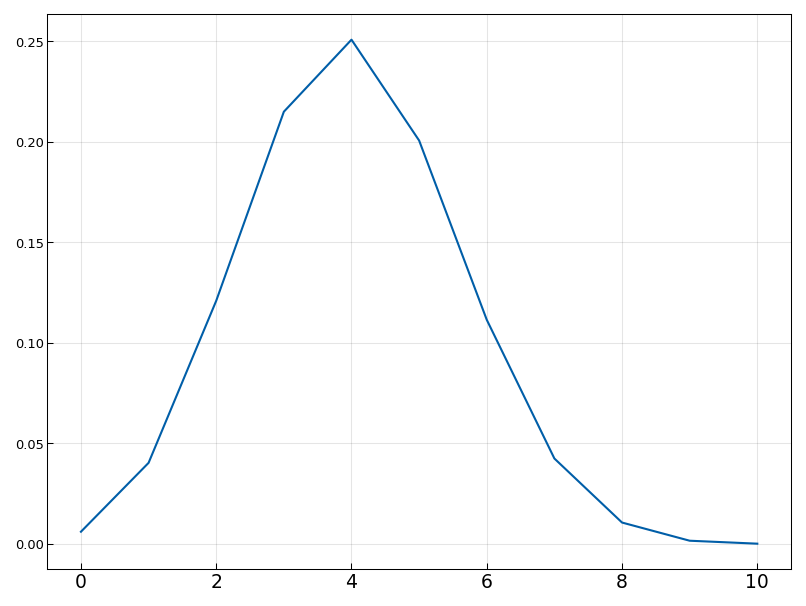

In [45]:
plt.plot(r, dists_e)

In [41]:
1 - (sum([(1-0.6)**i * dists_e[i] for i in range(N)])*0.6 + sum([(1-0.6)**i * dists_l[i] for i in range(N)])*0.4)

0.9501277040030301

Create the synthetic dataset D1, D2, D12, where D12 should be a combination of D1 and D2, with mixture ratio r.
We will use the 'Hidden Markov Model' here, however everything should also work with BN. (see appendix)

In [32]:
graph_lnl_I_II = {
            ("tumor", "primary"): ["I", "II"],
            ("lnl", "I"): [],
            ("lnl", "II"): [],
        }

lnls = ['I', 'II']


n_D1 = 300
n_D2 = 300
n_D12 = 300
r_12 = 0.6 # means 60% D2 and 40% D1 patients.

# Wheter we want the model to incorprate t-catergory late.
include_late = False

# Define spread prob. for HMM model 
params_d1 = [0.4, 0.0]
params_d2 = [0.0, 0.4]

t_dist = {'early': 1, 'late': 0}


# params_d1 = [0.6, 0.0, 0.05, 0.01, 0.1, 0.5]
# params_d2 = [0.0, 0.6, 0.05, 0.01, 0.1, 0.5]
# params_s2 = [0.2, 0.02, 0.05, 0.00, 0.1, 0.5]

model_data_gen = create_models_forked(1, graph=graph_lnl_I_II, include_late=include_late)

In [67]:
model_data_gen.assign_params(*params_d1)
data_synth_D1 = model_data_gen.generate_dataset(n_D1, t_dist)

model_data_gen.assign_params(*params_d2)
data_synth_D2 = model_data_gen.generate_dataset(n_D2, t_dist)

data_synth_D12 = create_synth_data(params_d1, params_d2, n_D12, r_12, graph_lnl_I_II, t_dist)


Prev Vector: {'II': 0, 'I': 0}: 0.29333333333333333{'II': 0, 'I': 1}: 0.7066666666666667{'II': 1, 'I': 0}: 0.0{'II': 1, 'I': 1}: 0.0
Prev Vector: {'II': 0, 'I': 0}: 0.3466666666666667{'II': 0, 'I': 1}: 0.0{'II': 1, 'I': 0}: 0.6533333333333333{'II': 1, 'I': 1}: 0.0
Prev Vector: {'II': 0, 'I': 0}: 0.27{'II': 0, 'I': 1}: 0.45666666666666667{'II': 1, 'I': 0}: 0.2733333333333333{'II': 1, 'I': 1}: 0.0


/var/folders/69/p_wbqzyx3031kxyydgwqmnnh0000gn/T/ipykernel_50745/4223927315.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


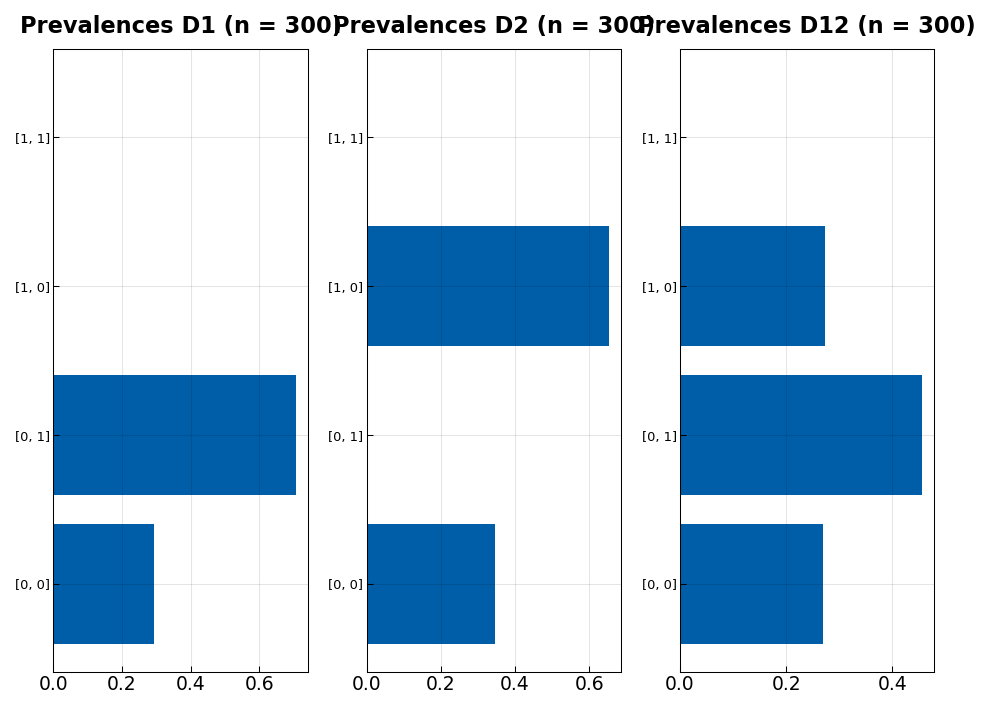

In [68]:
fig, ax = plt.subplots(1, 3, tight_layout = True)
create_prev_vectors(data_synth_D1, lnls, plot=True, title='D1', ax = ax[0])
create_prev_vectors(data_synth_D2, lnls, plot=True, title='D2', ax = ax[1])
create_prev_vectors(data_synth_D12, lnls, plot=True, title='D12', ax = ax[2])
fig.show()

In [57]:
# Check if prevalence is correct by colculating the risk based on the true model:
T = list(np.arange(10+1))
p_e = [sp.stats.binom.pmf(t, 10, 0.3) for t in T]
1-sum([(1-params_d1[0])**t * p_e[t] for t in T])

0.7214990239905981

Its correct!!

In [90]:
data_synth={'D1': data_synth_D1,
'D2': data_synth_D2,
'D12': data_synth_D12}

## Step 3: Sampling for D0 and D1

In [95]:
method = 'unilateral'
used_model = 'indp'

In [96]:


models = create_models(2, graph_lnl_I_II)
n_base_p = len(models[0].base_probs)
n_trans_p = len(models[0].trans_probs)
n_time_p = models[0].diag_time_dists.num_parametric
n_params_base = n_base_p + n_trans_p + n_time_p

nwalkers, nstep, burnin = 200, 2000, 1000

In [97]:
models[0].patient_data = data_synth['D1']

In [100]:
LOAD_DATA = False

SAVE_DIR = "samples/"
samples_S00_name = f"samples_D1_indp_uni_T1T2_synth_{r_12}"
samples_S01_name = f"samples_D2_indp_uni_2123_synth_{r_12}"

In [101]:
data_name = 'D1'
dtf = data_synth[data_name]
samples_name = samples_S00_name
model = models[0]

if LOAD_DATA:
    samples_S00 = np.load("samples/"+samples_name+".npy")
else:
    print(f"Loading data for data '{data_name}'.. Shape: {np.shape(dtf)}")
    model.patient_data = dtf
    print(f"Number of patients: {len(dtf)}")
    # define the log-likelihood
    def log_prob_fn(theta):
        return model.likelihood(given_params=theta, log=True)

    created_pool = mp.Pool(os.cpu_count())
    with created_pool as pool:
        starting_points = np.random.uniform(size=(nwalkers, n_params_base))
        original_sampler_mp = emcee.EnsembleSampler(
            nwalkers,
            n_params_base,
            log_prob_fn,
            pool=pool,
        )
        original_sampler_mp.run_mcmc(
            initial_state=starting_points, nsteps=nstep, progress=True
        )
    # Check acceptance ratio
    ar = np.mean(original_sampler_mp.acceptance_fraction)
    print(f"the HMM sampler for model 01 accepted {ar * 100 :.2f} % of samples.")
    samples_S00 = original_sampler_mp.get_chain(flat=True, discard=burnin)
    np.save(f"./samples/" + samples_name, samples_S00)

Loading data for data 'D1'.. Shape: (300, 3)
Number of patients: 300


100%|██████████| 2000/2000 [05:05<00:00,  6.55it/s]

the HMM sampler for model 01 accepted 54.18 % of samples.


In [102]:
data_name = 'D2'
dtf = data_synth[data_name]
samples_name = samples_S01_name
model = models[0]

if LOAD_DATA:
    samples_S00 = np.load("samples/"+samples_name+".npy")
else:
    print(f"Loading data for data '{data_name}'.. Shape: {np.shape(dtf)}")
    model.patient_data = dtf
    print(f"Number of patients: {len(dtf)}")
    # define the log-likelihood
    def log_prob_fn(theta):
        return model.likelihood(given_params=theta, log=True)

    created_pool = mp.Pool(os.cpu_count())
    with created_pool as pool:
        starting_points = np.random.uniform(size=(nwalkers, n_params_base))
        original_sampler_mp = emcee.EnsembleSampler(
            nwalkers,
            n_params_base,
            log_prob_fn,
            pool=pool,
        )
        original_sampler_mp.run_mcmc(
            initial_state=starting_points, nsteps=nstep, progress=True
        )
    # Check acceptance ratio
    ar = np.mean(original_sampler_mp.acceptance_fraction)
    print(f"the HMM sampler for model 01 accepted {ar * 100 :.2f} % of samples.")
    samples_D2 = original_sampler_mp.get_chain(flat=True, discard=burnin)
    np.save(f"./samples/" + samples_name, samples_S00)

Loading data for data 'D2'.. Shape: (300, 3)
Number of patients: 300


100%|██████████| 2000/2000 [05:23<00:00,  6.18it/s]


the HMM sampler for model 01 accepted 54.18 % of samples.


In [91]:
### Check the corner plots of these subsites
### Corner Plots of samples
from util import get_param_labels
import corner
def get_model_labels(models):

    model_labels = get_param_labels(models[0])
    # model_labels = [label.replace("->", "➜") for label in model_labels]
    model_labels = [label.replace("primary", "T") for label in model_labels]
    #model_labels = [model_labels[0], *model_labels[-len(model_oc.spread_probs):]]
    return model_labels
model_labels = get_model_labels(models)
model_labels

['T->I', 'T->II', 'late']

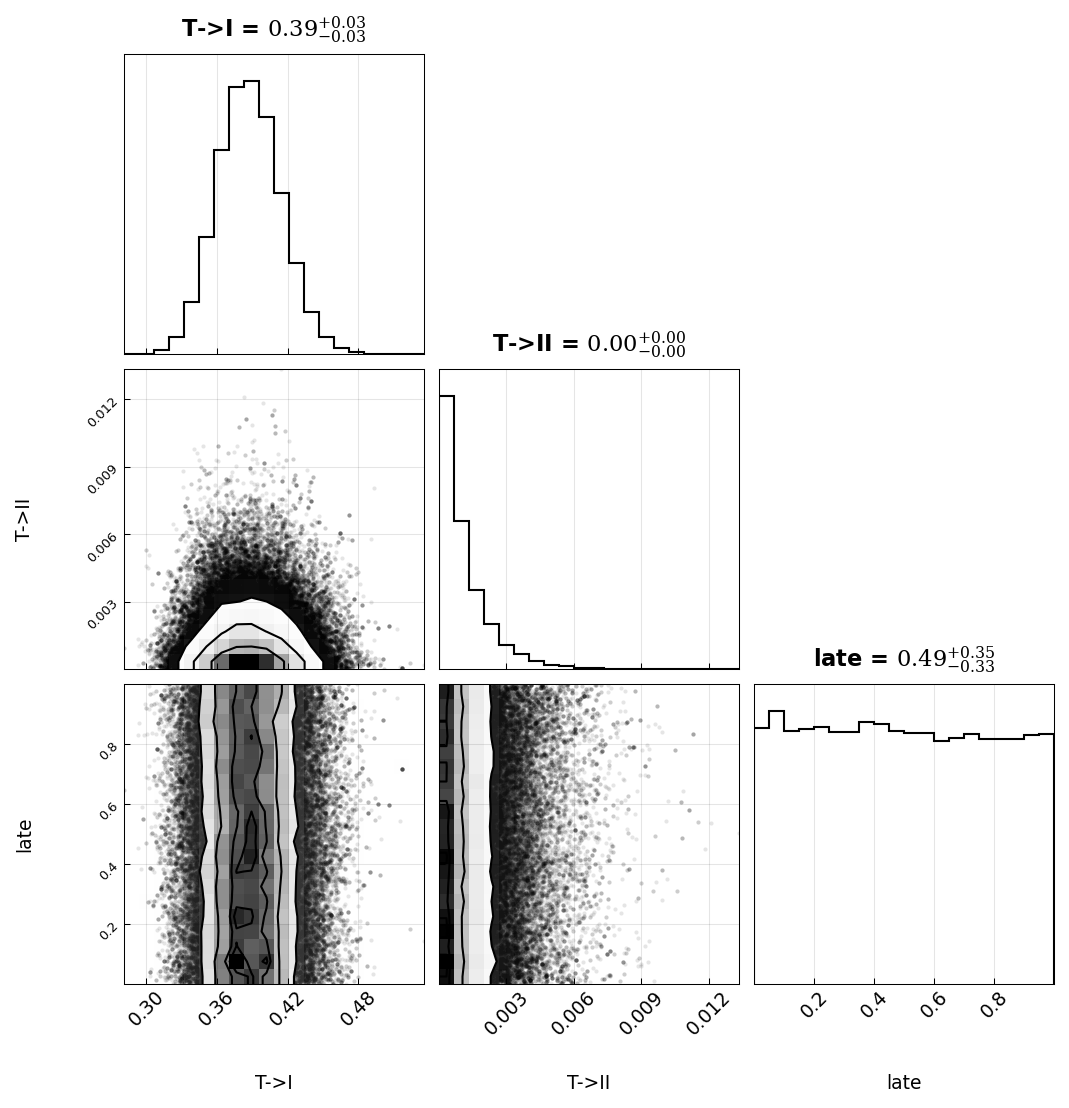

In [93]:
if LOAD_DATA is False or True:
    fig = corner.corner(
        samples_S00,
        labels=model_labels,
        show_titles=True,
    )
    plt.show()
    fig.savefig(PLOT_PATH / "corner_samplesS00_indp_2123_synth.svg")

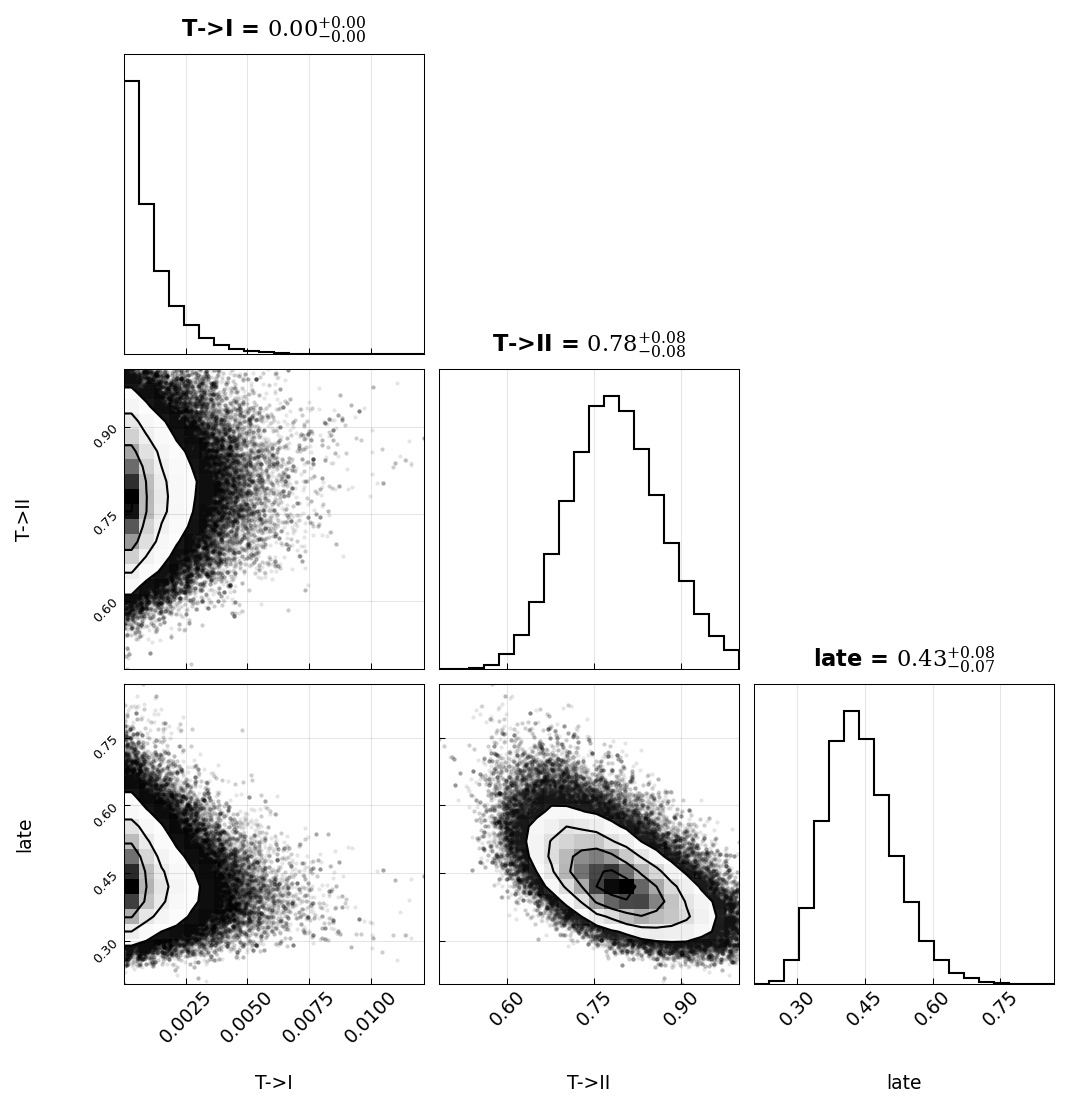

In [ ]:
if LOAD_DATA is False or True:
    fig = corner.corner(
        samples_S01,
        labels=model_labels,
        show_titles=True,
    )
    plt.show()
    fig.savefig(PLOT_PATH / "corner_samplesS01_indp_2123_synth.svg")

## Calculate the likelihood for the patients in S02, with the samples from S00 and S01

First we check for a dataset with a 1to1 ratio of patients from s0 and s1.

In [74]:
import random
model = models[0]

data_synth_s2_1to1 = create_synth_data(params_s0, params_s1, 200, 0.5, graph, t_dist)
model.patient_data = data_synth_s2_1to1


In [75]:
# Draw samples from posterios (here just define the indexes)
n = 500
random_idx = random.sample(range(samples_S00.shape[0]), n)


In [76]:
llhs_S02_S00 = []
for idx in random_idx:
    llhs_S02_S00.append(model.likelihood(given_params=samples_S00[idx, :]))
llhs_S02_S01 = []
for idx in random_idx:
    llhs_S02_S01.append(model.likelihood(given_params=samples_S01[idx, :]))

In [78]:

fig, ax = plt.subplots(1, figsize=set_size('full'))
bins = 20
ax.hist(llhs_S02_S00, color=usz_green, alpha = 0.8, bins = bins, label = f"llh of S2 on S0 (mean = {np.mean(llhs_S02_S00) :.2f})")
ax.hist(llhs_S02_S01, color=usz_red, alpha = 0.8, bins = bins, label = f"llh of S2 on S1 (mean = {np.mean(llhs_S02_S01) :.2f})")
ax.set_xlabel('llh')
plt.legend()

fig.savefig(PLOT_PATH / "hist_llh_S02_S00S01_synth_1to1.svg")
fig.savefig(PLOT_PATH / "hist_llh_S02_S00S01_synth_1to1.png")

In [50]:
### What happens if we have an unevenly distributed dataset

data_synth_s2_0p6 = create_synth_data(params_s0, params_s1, 200, 0.6, graph, t_dist)
model.patient_data = data_synth_s2_0p6

In [51]:
llhs_S02_S00 = []
for idx in random_idx:
    llhs_S02_S00.append(model.likelihood(given_params=samples_S00[idx, :]))
llhs_S02_S01 = []
for idx in random_idx:
    llhs_S02_S01.append(model.likelihood(given_params=samples_S01[idx, :]))


fig, ax = plt.subplots(1, figsize=set_size('full'))
bins = 20
ax.hist(llhs_S02_S00, color=usz_green, bins = bins, label = f"llh of S2 on S0 (mean = {np.mean(llhs_S02_S00) :.2f})")
ax.hist(llhs_S02_S01, color=usz_red, bins = bins, label = f"llh of S2 on S1 (mean = {np.mean(llhs_S02_S01) :.2f})")
ax.set_xlabel('llh')
plt.legend()

fig.savefig(PLOT_PATH / "hist_llh_S02_S00S01_synth_0p6.svg")

In [52]:
data_s1_250 = data_synth['s1']


CHeck the dependency of the likelihood to the number of patients

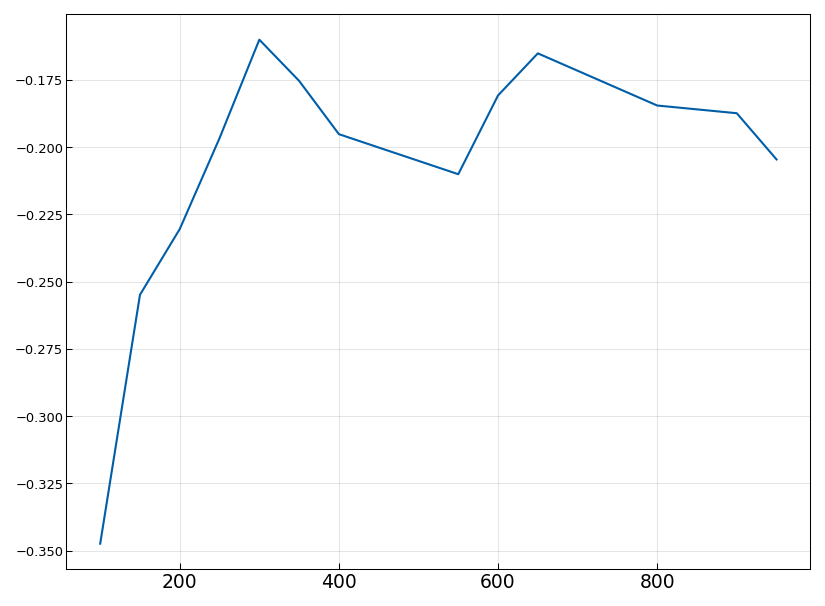

In [58]:
llhs = []
ipat = []
for i in range(100, 1000, 50):
    try:
        data_s1_500 = create_synth_data(params_s1, params_s1, i, 1, graph_lnl_I_II, t_dist)
        model_s1 = create_models(1, graph_lnl_I_II)
        model_s1.patient_data = data_s1_500
        llhs_p1_s1 = []
        for idx in random_idx:
            llhs_p1_s1.append(model_s1.likelihood(given_params=samples_S01[idx, :]))
        llhs.append(np.mean(llhs_p1_s1)/i)
        ipat.append(i)
    except:
        pass
plt.plot(ipat, llhs)
plt.show()


## Create mixture model and fix mixture components to 1 for S00 and S01

In [78]:
global MODELS

models = create_models(3, graph = graph_lnl_I_II)

n_base_p = len(models[0].base_probs)
n_trans_p = len(models[0].trans_probs)
n_time_p = models[0].diag_time_dists.num_parametric
n_params_base = n_base_p + n_trans_p + n_time_p
ndim = n_params_base*2 + 1





In [60]:
data_synth['s2'] = create_synth_data(params_s0, params_s1, 200, 0.6, graph_lnl_I_II, t_dist)

In [79]:
# Load the data
for i, (s_name, s_data) in enumerate(data_synth.items()):
    try:
        print(f"Loading data for subsite '{s_name}'.. Shape: {np.shape(s_data)}")
        models[i].patient_data = s_data
    except Exception as e:
        print(f"Error in loading data for cluster {s_name}.")
        print(e)
MODELS=models

Loading data for subsite 'D1'.. Shape: (300, 3)


Loading data for subsite 'D2'.. Shape: (300, 3)
Loading data for subsite 'D12'.. Shape: (300, 3)


In [80]:
C = np.array([[1,0], [0,1], [0.5, 0.5]])

emcee_args = [n_params_base, C] 

In [81]:
def log_prob_k_cluster(theta, n_graph_p, C):
    m = theta[-1]
    if m<0 or m> 1:
        return -np.inf
    C[2,0] = m
    C[2,1] = 1 - m
    llh = 0
    for s in range(3):
        model = MODELS[s]
        log_sum = 0
        pi0 = C[s,0]
        pi1 = C[s,1]
        params0 = theta[0: (1)*n_graph_p]
        params1 = theta[1*n_graph_p: (2)*n_graph_p]
        log_sum_0 = -np.inf
        log_sum_1 = -np.inf
        if pi0 != 0:
            log_sum_0 = np.log(pi0) + model.likelihood(given_params=params0, log = True)
        if pi1 != 0:
            log_sum_1 = np.log(pi1) + model.likelihood(given_params=params1, log = True)

        log_sum = np.logaddexp(log_sum_0, log_sum_1)
        # llh += ( C[s,k]*model.likelihood(given_params=params, log = True))
        llh += log_sum
    if np.isnan(llh):
        return -np.inf

    if np.isinf(llh):
        return -np.inf
    return llh

In [64]:
# check if likelihood function works
a = 0
param1 = np.array([0.0393634 , 0.07910263, 0.02163931, 0.05738574, 0.0466186 ,
       0.70873849, 0.0393634 ])
log_prob_k_cluster(param1, n_params_base, C)

-1683.7590273091437

In [82]:
nwalkers, nstep, burnin = 20*ndim, 3000, 1000
thin_by = 3
print(f"Dimension: {ndim} with n walkers: {nwalkers}")
output_name = f"samples_2_cluster_fix_D1D2_T1T2_synth_{r_12}"

if False:
    samples = np.load("samples/"+output_name+".npy")
else:
    created_pool = mp.Pool(os.cpu_count())
    with created_pool as pool:
        starting_points = np.random.uniform(size=(nwalkers, ndim))
        print(f"Start Burning (steps = {burnin}) with {created_pool._processes} cores")
        burnin_sampler = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            log_prob_k_cluster,
            args=emcee_args,
            pool=pool,
        )
        burnin_results = burnin_sampler.run_mcmc(
            initial_state=starting_points, nsteps=burnin, progress=True
        )
        
        ar = np.mean(burnin_sampler.acceptance_fraction)
        print(f"the HMM sampler for model 01 accepted {ar * 100 :.2f} % of samples.")
        last_sample = burnin_sampler.get_last_sample()[0]
        print(f"The shape of the last sample is {last_sample.shape}")
        starting_points = np.random.uniform(size=(nwalkers, ndim))
        original_sampler_mp = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            log_prob_k_cluster,
            args=emcee_args,
            backend=None,
            pool=pool,
        )
        sampling_results = original_sampler_mp.run_mcmc(
            initial_state=last_sample, nsteps=nstep, progress=True, thin_by = thin_by
        )

    ar = np.mean(original_sampler_mp.acceptance_fraction)
    print(f"the HMM sampler for model accepted {ar * 100 :.2f} % of samples.")
    samples_cl = original_sampler_mp.get_chain(flat=True)
    np.save(f"./samples/" + output_name, samples_cl)
    # plots["acor_times"].append(burnin_info["acor_times"][-1])
    # plots["accept_rates"].append(burnin_info["accept_rates"][-1])


Dimension: 7 with n walkers: 140


Start Burning (steps = 1000) with 8 cores


100%|██████████| 1000/1000 [03:16<00:00,  5.10it/s]


the HMM sampler for model 01 accepted 35.15 % of samples.
The shape of the last sample is (140, 7)


100%|██████████| 9000/9000 [24:38<00:00,  6.09it/s]


the HMM sampler for model accepted 34.10 % of samples.


In [83]:

samples_cl_0 = samples_cl[:, :n_params_base]
samples_cl_1 = samples_cl[:, n_params_base: 2*n_params_base]
mixing = samples_cl[:,-1]

print(f"mean mixing pi20= {mixing.mean(axis =0 ) :.2f}")


mean mixing pi20= 0.67


In [86]:
model_labels = get_param_labels(models[0])
# model_labels = [label.replace("->", "➜") for label in model_labels]
model_labels = [label.replace("primary", "T") for label in model_labels]
model_labels.append(r'$\pi_{2,0}$') if '$\pi_{2,0}' not in model_labels else ''
model_labels

['T->I', 'T->II', 'late', '$\\pi_{2,0}$']

KeyError: 'colors_llh'

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Lucida Calligraphy
findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'monospace' not found because none of the following families were found: Ubuntu Mono


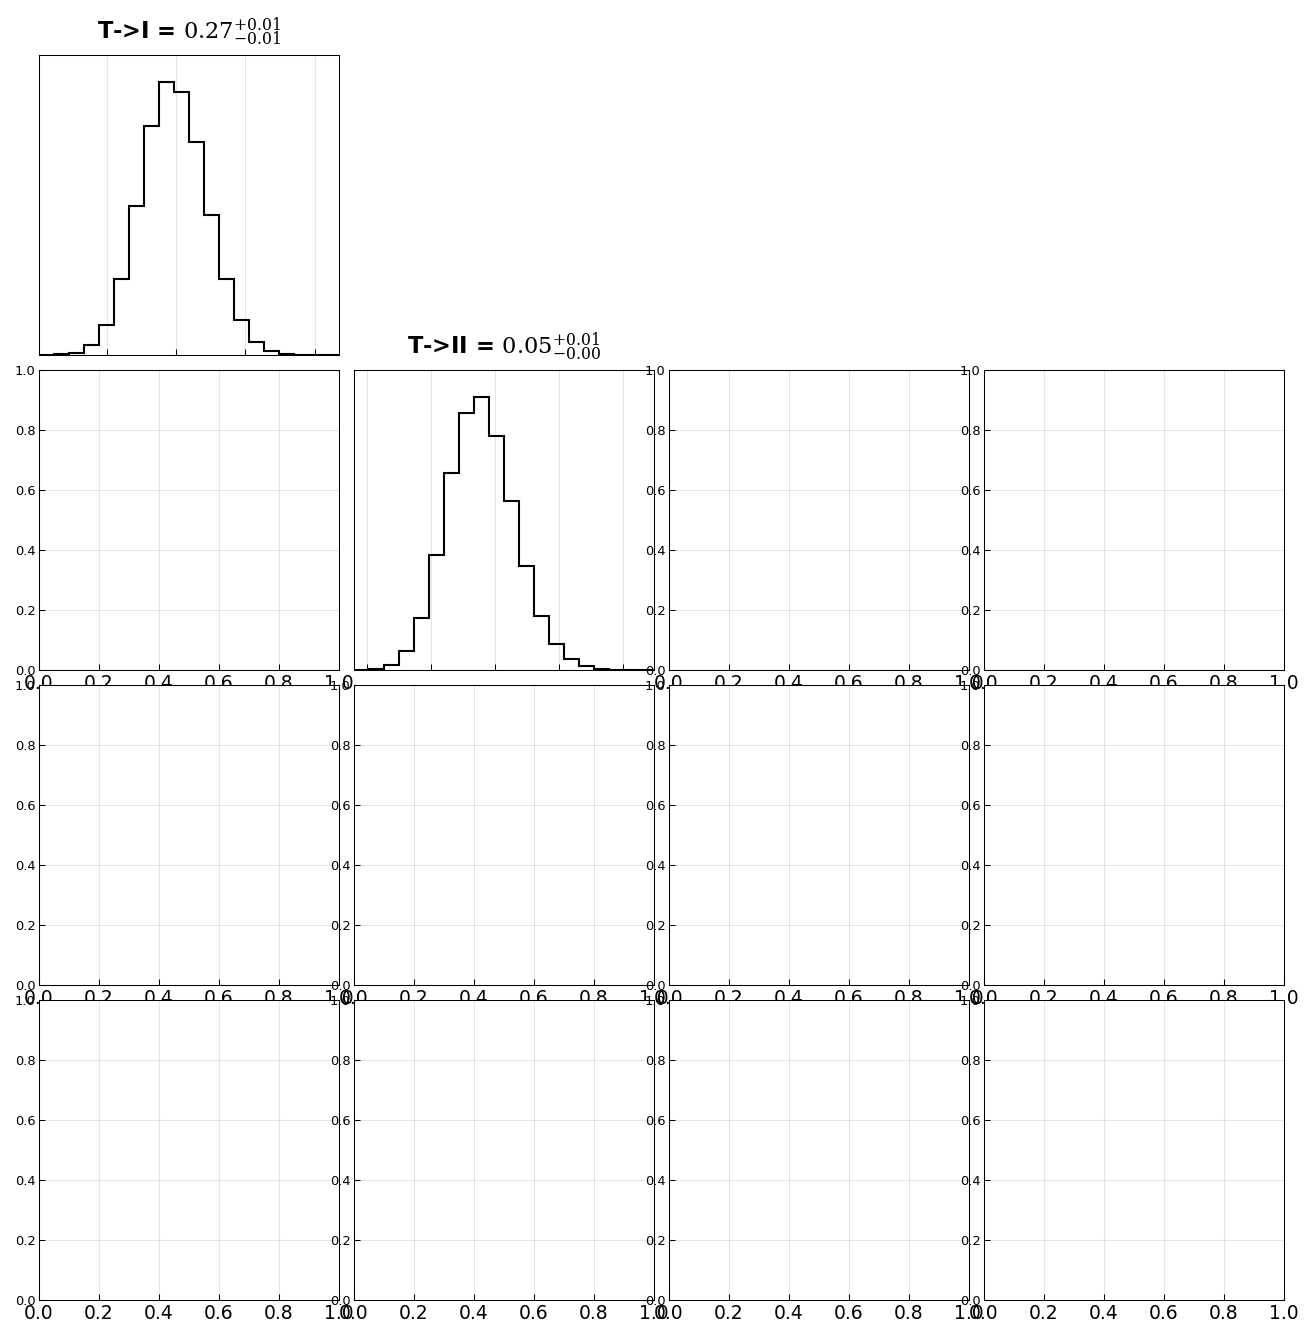

In [87]:
truths = samples_S00.mean(axis = 0)
truths = np.append(truths, 0)
fig = corner.corner(
    np.column_stack((samples_cl_0, mixing)),
    labels=model_labels,
    show_titles=True,
    truths = truths
)
plt.show()
fig.savefig(PLOT_PATH / f"corner_cluster0_{output_name}.svg")


model_labels[-1] = '1-pi'


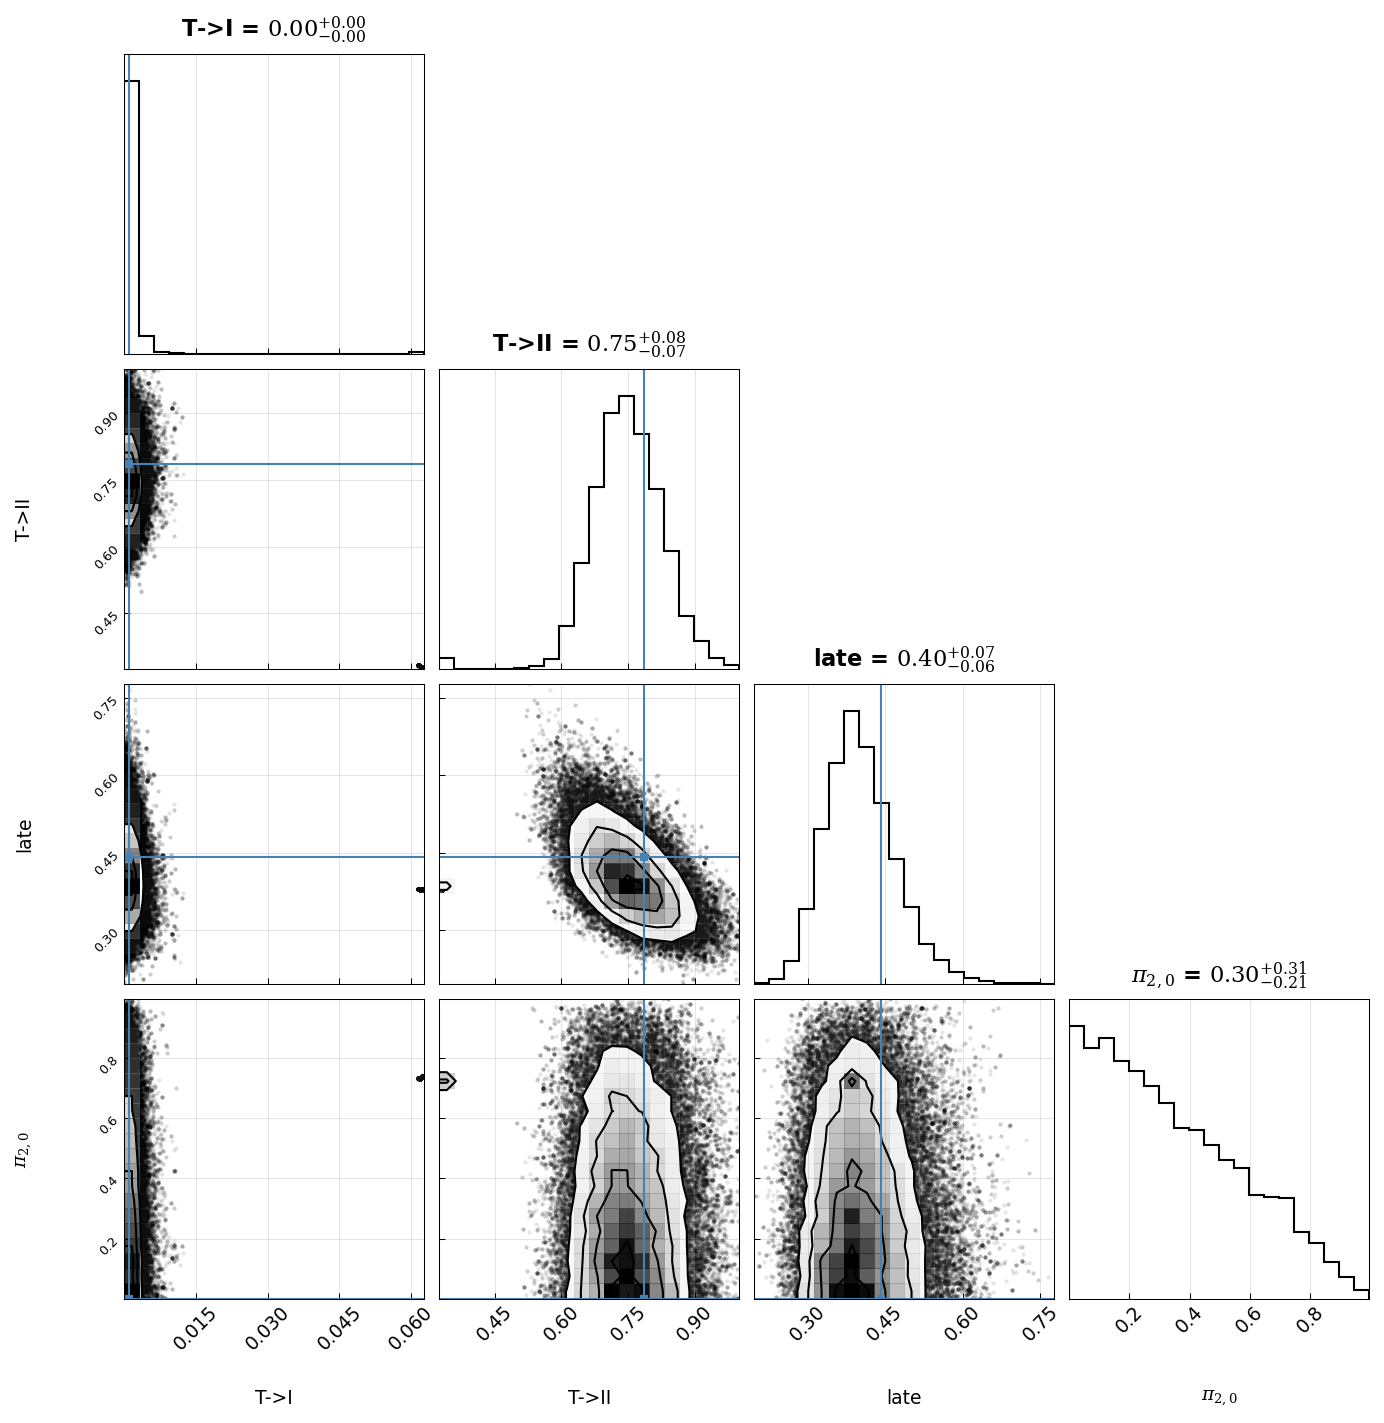

In [86]:
model_labels = get_param_labels(models[0])
# model_labels = [label.replace("->", "➜") for label in model_labels]
model_labels = [label.replace("primary", "T") for label in model_labels]
model_labels.append(r'$\pi_{2,0}$') if '$\pi_{2,1}' not in model_labels else ''

truths = samples_S01.mean(axis = 0)
truths = np.append(truths, 0)

fig = corner.corner(
    np.column_stack((samples_cl_1, 1-mixing)),
    labels=model_labels,
    show_titles=True,
    truths = truths
)
plt.show()
fig.savefig(PLOT_PATH / f"corner_cluster1_{output_name}.svg")

Again we see the same behaviour, where the parameters for cluster 0 get changed and the model assigns the S2 patients to cluster 0.

Check what happens when we use an equally distributed dataset(0.5)

### Equally distributed s3 dataset

In [69]:
ratio = 0.5
data_synth['s2'] = create_synth_data(params_s0, params_s1, 200, ratio, graph_lnl_I_II, t_dist)

output_name = "samples_2_cluster_fix_s00s01_12_synth_05"
LOAD_DATA = True

 State: {'II': 1, 'I': 1}

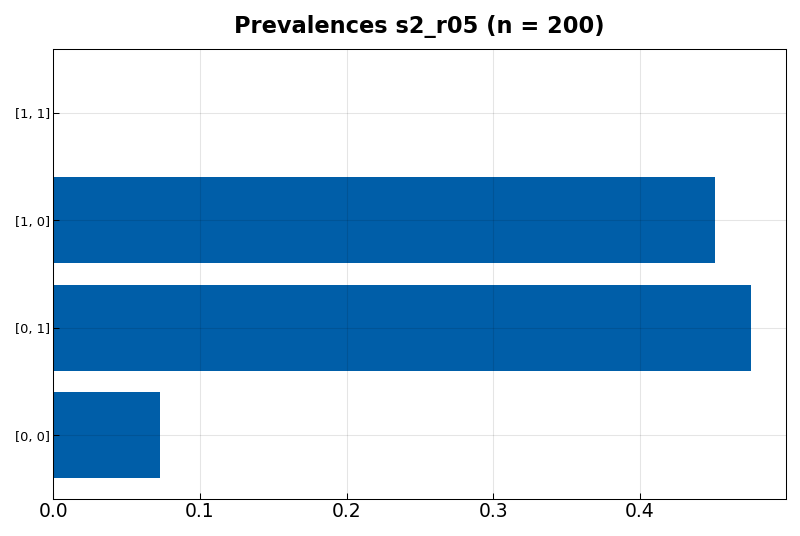

[0.07258064516129033, 0.47580645161290325, 0.45161290322580644, 0.0]

In [72]:
create_prev_vectors(data_synth['s2'], lnls=lnls, plot = True, title = 's2_r05')

In [82]:
# Load the data
for i, (s_name, s_data) in enumerate(data_synth.items()):
    try:
        print(f"Loading data for subsite '{s_name}'.. Shape: {np.shape(s_data)}")
        models[i].patient_data = s_data
    except Exception as e:
        print(f"Error in loading data for cluster {s_name}.")
        print(e)
MODELS=models

# Reset the mixing parameters
C = np.array([[1,0], [0,1], [0.5, 0.5]])
emcee_args = [n_params_base, C] 

# Start the sampling process
nwalkers, nstep, burnin = 20*ndim, 1000, 1000
print(f"Dimension: {ndim} with n walkers: {nwalkers}")


if LOAD_DATA:
    samples = np.load("samples/"+output_name+".npy")
    samples = np.load("samples/"+output_name+".npy")
else:
    created_pool = mp.Pool(os.cpu_count())
    with created_pool as pool:
        starting_points = np.random.uniform(size=(nwalkers, ndim))
        print(f"Start Burning (steps = {burnin}) with {created_pool._processes} cores")
        burnin_sampler = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            log_prob_k_cluster,
            args=emcee_args,
            pool=pool,
        )
        burnin_results = burnin_sampler.run_mcmc(
            initial_state=starting_points, nsteps=burnin, progress=True
        )
        
        ar = np.mean(burnin_sampler.acceptance_fraction)
        print(f"the HMM sampler for model 01 accepted {ar * 100 :.2f} % of samples.")
        last_sample = burnin_sampler.get_last_sample()[0]
        print(f"The shape of the last sample is {last_sample.shape}")
        starting_points = np.random.uniform(size=(nwalkers, ndim))
        original_sampler_mp = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            log_prob_k_cluster,
            args=emcee_args,
            backend=None,
            pool=pool,
        )
        sampling_results = original_sampler_mp.run_mcmc(
            initial_state=last_sample, nsteps=nstep, progress=True
        )

    ar = np.mean(original_sampler_mp.acceptance_fraction)
    print(f"the HMM sampler for model accepted {ar * 100 :.2f} % of samples.")
    samples = original_sampler_mp.get_chain(flat=True)
    np.save(f"./samples/" + output_name, samples)
    # plots["acor_times"].append(burnin_info["acor_times"][-1])
    # plots["accept_rates"].append(burnin_info["accept_rates"][-1])


Loading data for subsite 's0'.. Shape: (250, 3)
Loading data for subsite 's1'.. Shape: (250, 3)
Loading data for subsite 's2'.. Shape: (200, 3)
Dimension: 7 with n walkers: 140


In [83]:
# we want to visualize the log probabilities

from matplotlib.colors import Normalize
from matplotlib.colorbar import Colorbar


In [85]:
if LOAD_DATA:
    log_probs = np.load(f"./samples/" + "log_probs_" +output_name + ".npy")
else:
    log_probs = original_sampler_mp.get_log_prob(flat=True)
np.save(f"./samples/" + "log_probs_" +output_name, log_probs)

In [86]:
colormap = plt.cm.viridis
norm = Normalize(vmin=log_probs.min(), vmax=log_probs.max())
colors = colormap(norm(log_probs))

In [87]:

samples_cl_0 = samples[:, :n_params_base]
samples_cl_1 = samples[:, n_params_base: 2*n_params_base]
mixing = samples[:,-1]

print(f"mean mixing pi20= {mixing.mean(axis =0 ) :.2f}")


mean mixing pi20= 0.54


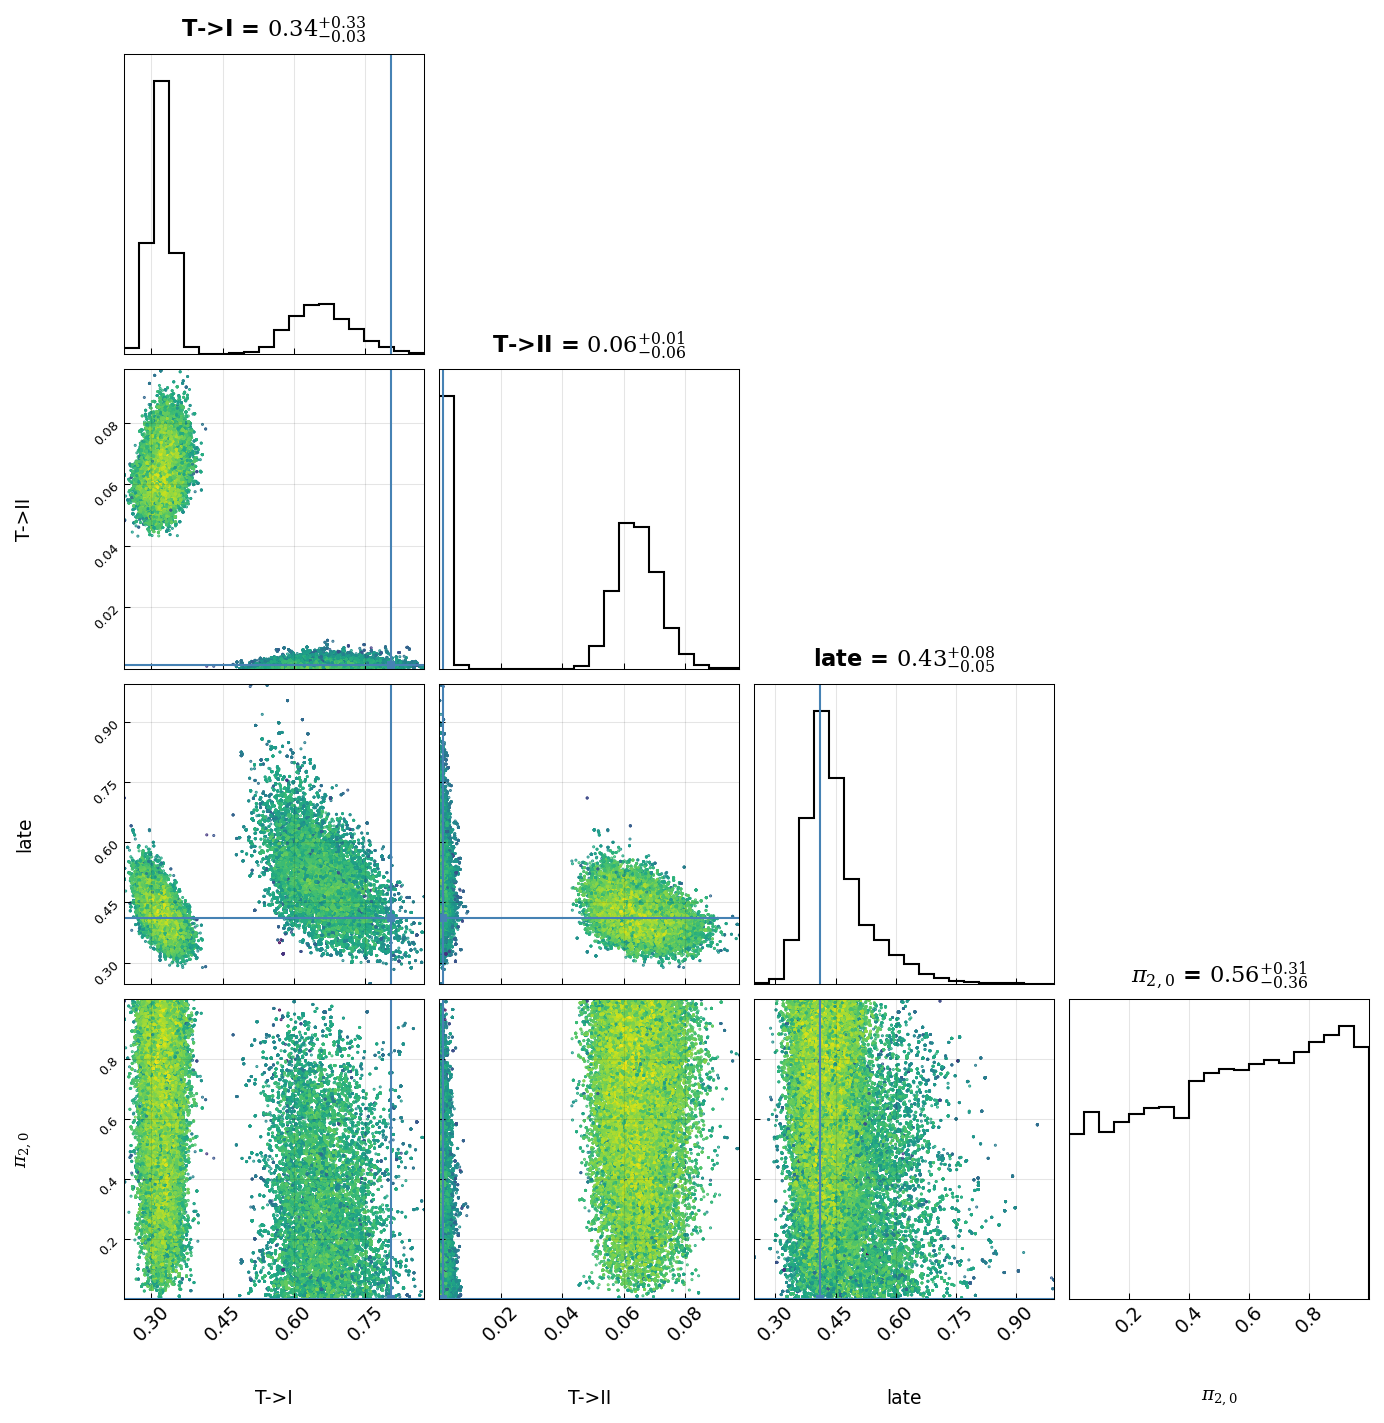

In [89]:
truths = samples_S00.mean(axis = 0)
truths = np.append(truths, 0)
fig = corner.corner(
    np.column_stack((samples_cl_0, mixing)),
    labels=model_labels,
    show_titles=True,
    plot_contours = False,
    plot_density = False,
    no_fill_contours = True,
    truths = truths,
    data_kwargs= {"colors_llh": colors}
)
plt.show()
# fig.savefig(PLOT_PATH / f"corner_cluster0_{output_name}.svg")
fig.savefig(PLOT_PATH / f"corner_cluster0_{output_name}.png")


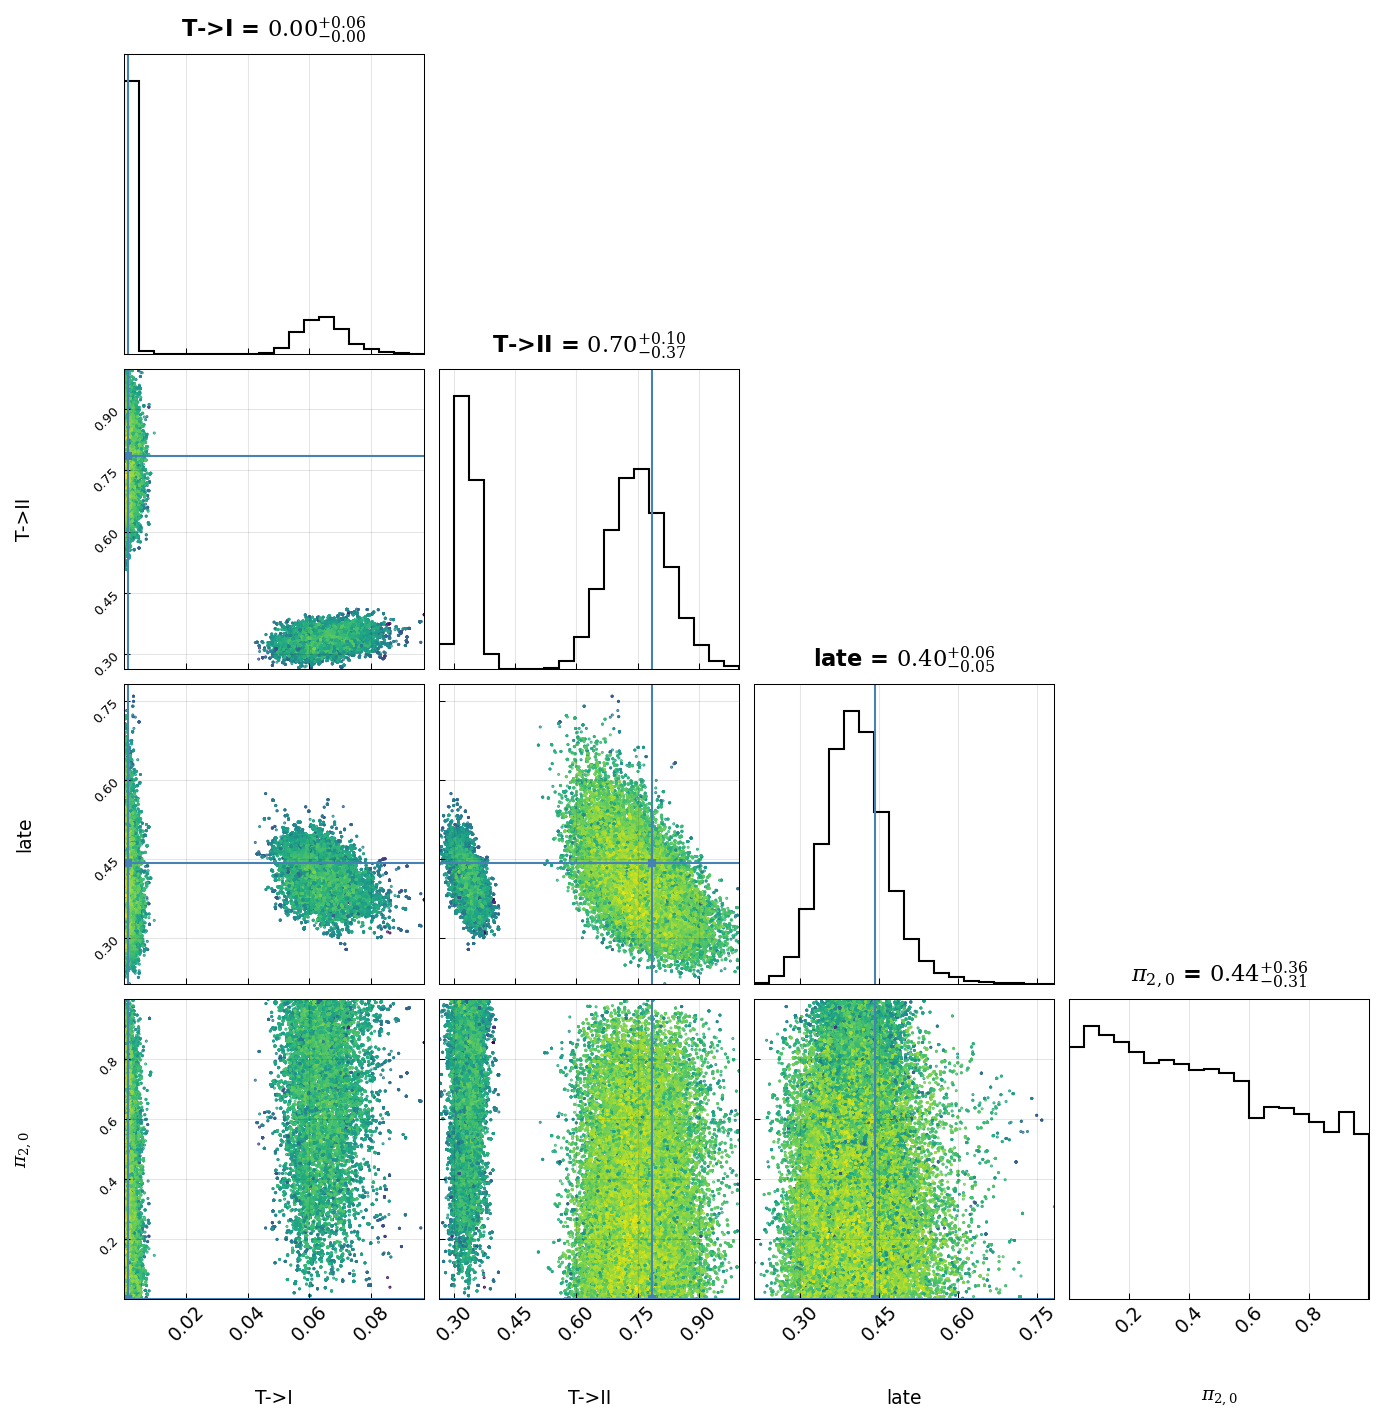

In [90]:
model_labels = get_param_labels(models[0])
# model_labels = [label.replace("->", "➜") for label in model_labels]
model_labels = [label.replace("primary", "T") for label in model_labels]
model_labels.append(r'$\pi_{2,0}$') if '$\pi_{2,1}' not in model_labels else ''

truths = samples_S01.mean(axis = 0)
truths = np.append(truths, 0)
fig = corner.corner(
    np.column_stack((samples_cl_1, 1-mixing)),
    labels=model_labels,
    show_titles=True,
    truths = truths,
    plot_contours = False,
    plot_density = False,
    no_fill_contours = True,
    data_kwargs= {"colors_llh": colors}
)
plt.show()
# fig.savefig(PLOT_PATH / f"corner_cluster1_{output_name}.svg")
fig.savefig(PLOT_PATH / f"corner_cluster1_{output_name}.png")

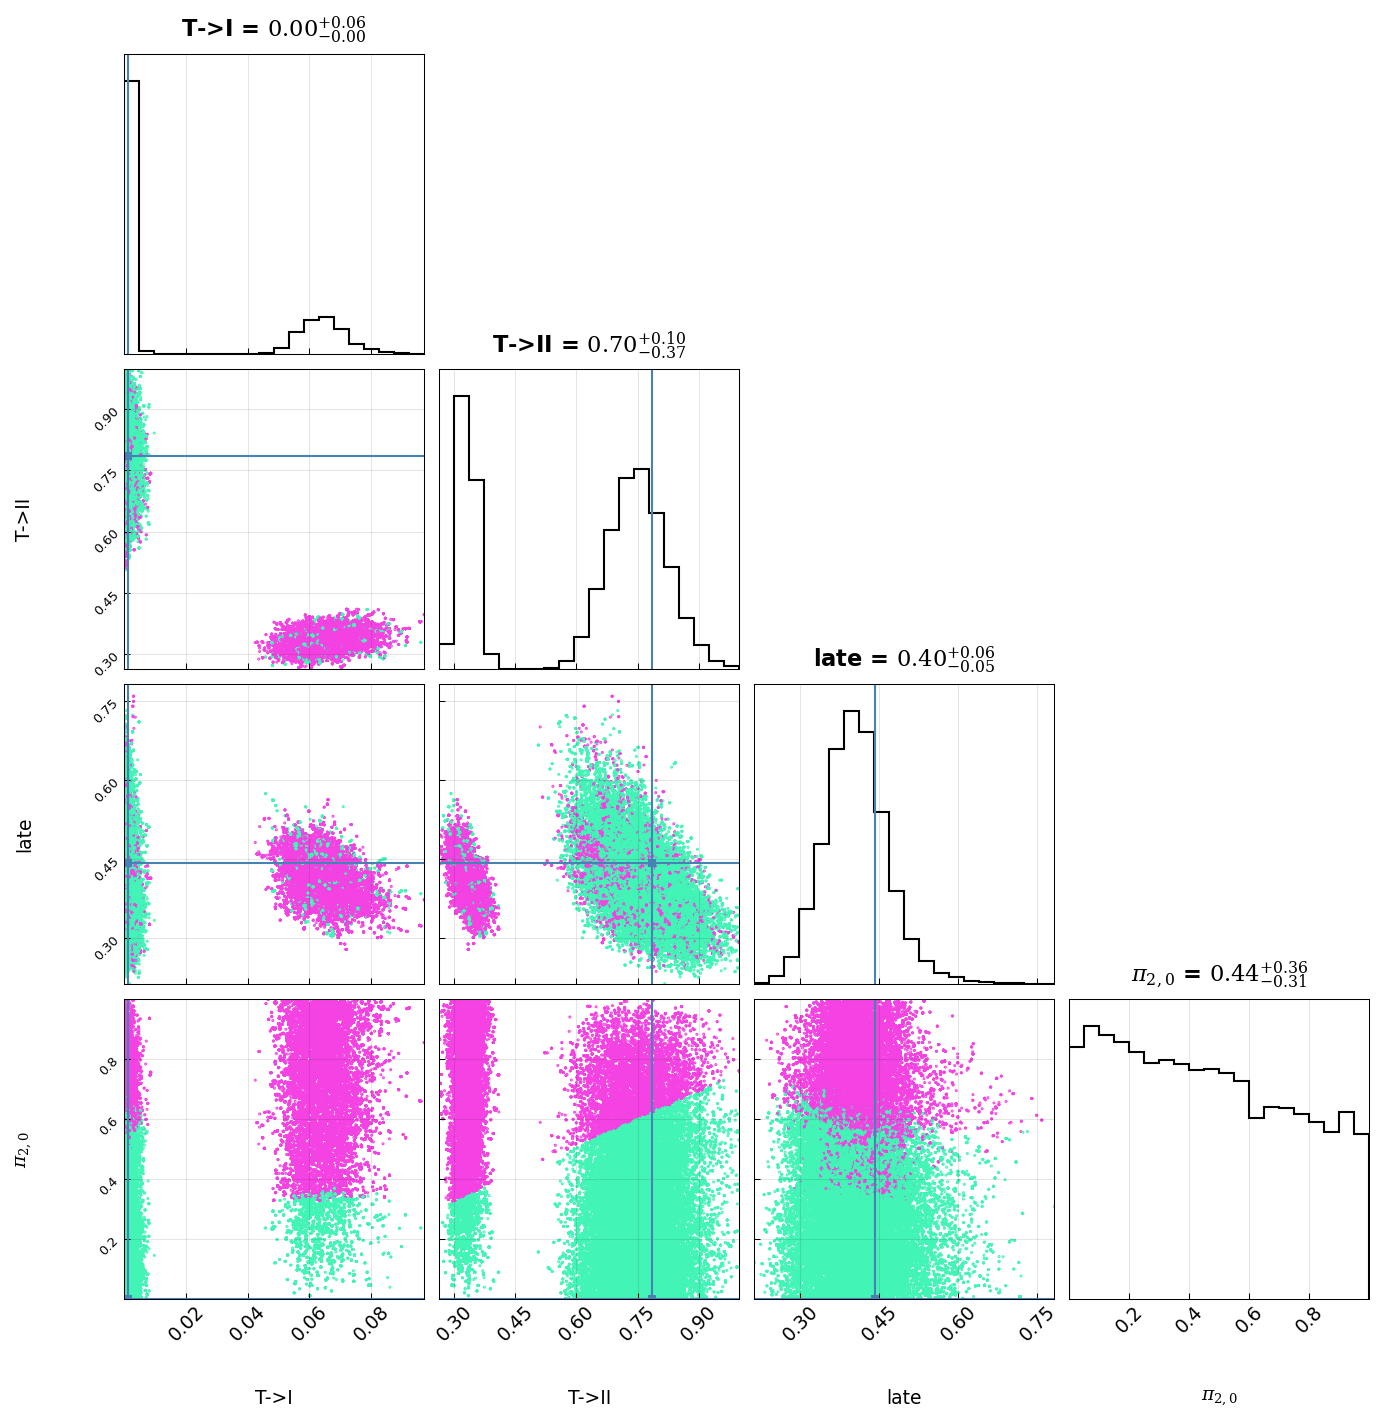

In [101]:
model_labels = get_param_labels(models[0])
# model_labels = [label.replace("->", "➜") for label in model_labels]
model_labels = [label.replace("primary", "T") for label in model_labels]
model_labels.append(r'$\pi_{2,0}$') if '$\pi_{2,1}' not in model_labels else ''

truths = samples_S01.mean(axis = 0)
truths = np.append(truths, 0)
fig = corner.corner(
    np.column_stack((samples_cl_1, 1-mixing)),
    labels=model_labels,
    show_titles=True,
    truths = truths,
    plot_contours = False,
    plot_density = False,
    no_fill_contours = True,
    data_kwargs= {"colors_llh": [cd[l] for l in mc_labels]}
)
plt.show()
# fig.savefig(PLOT_PATH / f"corner_cluster1_{output_name}.svg")
fig.savefig(PLOT_PATH / f"corner_cluster1_colored_clusters_{output_name}.png")

Now the problem is perfectly visible, the posterior distribution will always jump between two local minimas, so i

### We can check wether the algorithm jumps back and forth between the two clusters, or if the algorithm converges to a certain pattern at the end.

In [92]:
from sklearn.cluster import KMeans

In [93]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10).fit(np.column_stack((samples_cl_1, 1-mixing)))
mc_labels = kmeans.labels_

In [97]:
cd = {0: '#42f5b6', 1:'#f542e3'}
fig, ax = plt.subplots()
ax.scatter(range(len(log_probs)), log_probs, s = 0.2, color = [cd[l] for l in mc_labels])
ax.set_xlabel('step')
ax.set_ylabel('llh')
fig.show()
fig.savefig(PLOT_PATH / f"llhs_vs_sampling_{output_name}.png")

In [98]:
window = 1000
rolling = []
for i in range(window, len(mc_labels)):
    rolling.append(mc_labels[i-window:i].sum() / window)
fig, ax = plt.subplots()
ax.set_xlabel('step')
ax.set_ylabel('ratio')
ax.plot(range(len(rolling)), rolling)
fig.show()
fig.savefig(PLOT_PATH / f"step_vs_samplingclusters_{output_name}.png")



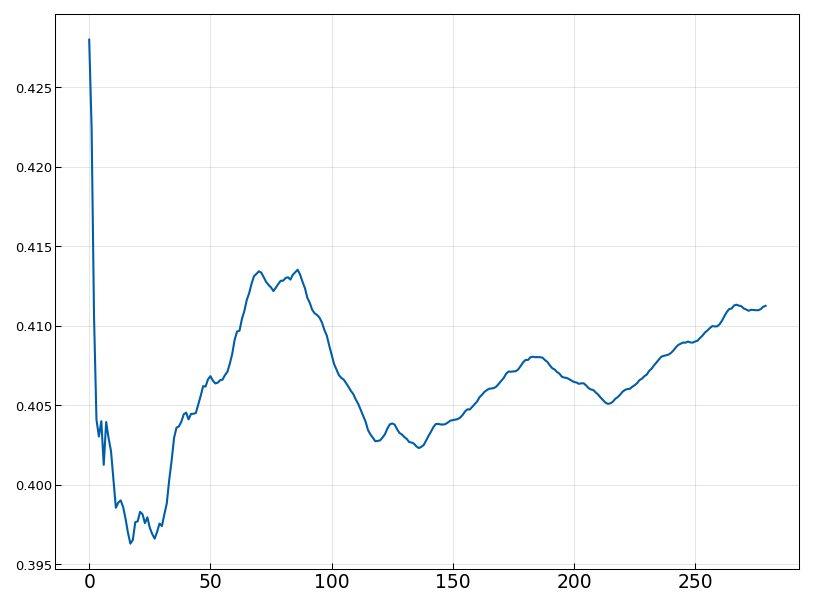

In [156]:
n = 500
iterations = range(int(np.ceil(len(mc_labels) / n)))
counts = []
for i in iterations:
    slice_l = mc_labels[i:(i+1)*n]
    counts.append(np.count_nonzero(slice_l) / len(slice_l))
    
plt.plot(iterations, counts)


### Try to really fix the parameters for sigma_0 and sigma_1

In [139]:
def log_prob_fixed_samples(theta, samples_0, samples_1):
    if theta > 1 or theta < 0:
        return -np.inf
    log_sum_0 = -np.inf
    log_sum_1 = -np.inf
    if theta != 0:
        log_sum_0 = np.log(theta) + MODELS[2].likelihood(given_params=samples_0, log = True)
    if theta!= 1:
        log_sum_1 = np.log(1-theta) + MODELS[2].likelihood(given_params=samples_1, log = True)
    log_sum = np.logaddexp(log_sum_0, log_sum_1)
    if np.isnan(log_sum):
        return -np.inf
    return log_sum

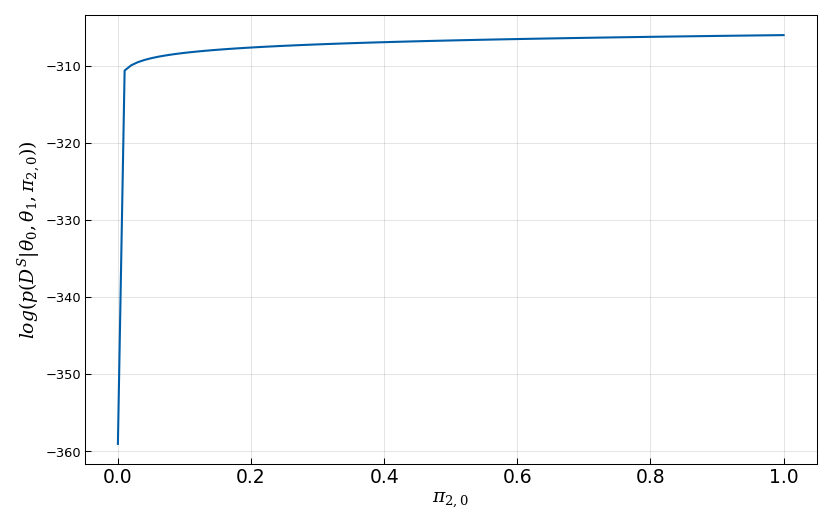

In [88]:
xs = np.linspace(0,1,100)
s0, s1 = samples_S00.mean(axis = 0), samples_S01.mean(axis = 0)
fig,ax = plt.subplots(1, figsize=set_size(width='full'))
ax.plot(xs, [log_prob_fixed_samples(x, s0, s1) for x in xs] , color = usz_blue)
ax.set_xlabel(r'$\pi_{2,0}$')
ax.set_ylabel(r'$log(p(D^S|{\theta_0, \theta_1, \pi_{2,0}}))$')
plt.show()
fig.savefig(PLOT_PATH / "line_llh_prob_dataS2_vs_mixing_synth.svg")

In [91]:
import random
random_idx = random.sample(range(samples_S00.shape[0]), 100)

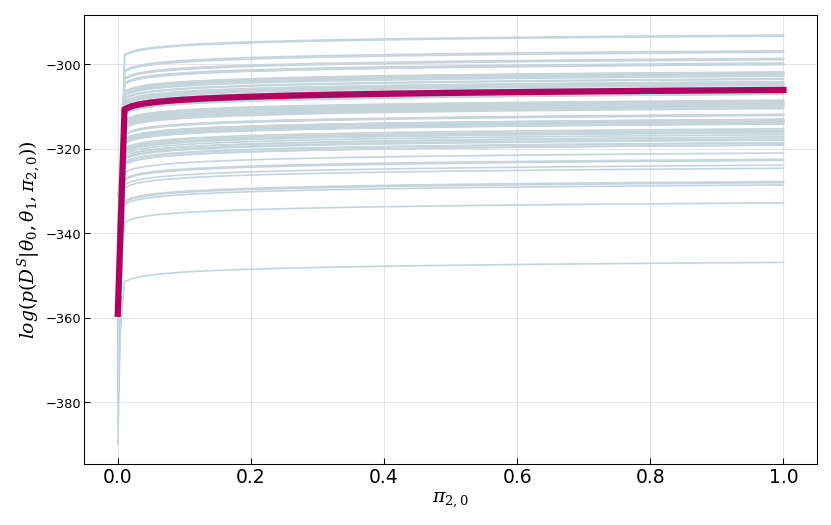

In [92]:
# How does it look like if we sample from the posterior?
n_lines = 100
random_idx = random.sample(range(len(samples_S00)), n_lines)

xs = np.linspace(0,1,100)
fig,ax = plt.subplots(1, figsize=set_size(width='full'))
for i in range(n_lines):
    ax.plot(xs, [log_prob_fixed_samples(x, samples_S00[random_idx[i]], samples_S01[random_idx[i]]) for x in xs] , color = usz_gray, linewidth = 0.8, linestyle = 'solid')
    
s0, s1 = samples_S00.mean(axis = 0), samples_S01.mean(axis = 0)
ax.plot(xs, [log_prob_fixed_samples(x, s0, s1) for x in xs] , color = usz_red, linewidth = 3)
ax.set_xlabel(r'$\pi_{2,0}$')
ax.set_ylabel(r'$log(p(D^S|{\theta_0, \theta_1, \pi_{2,0}}))$')
plt.show()
fig.savefig(PLOT_PATH / "line_llh_prob_dataS2_vs_mixing.svg")

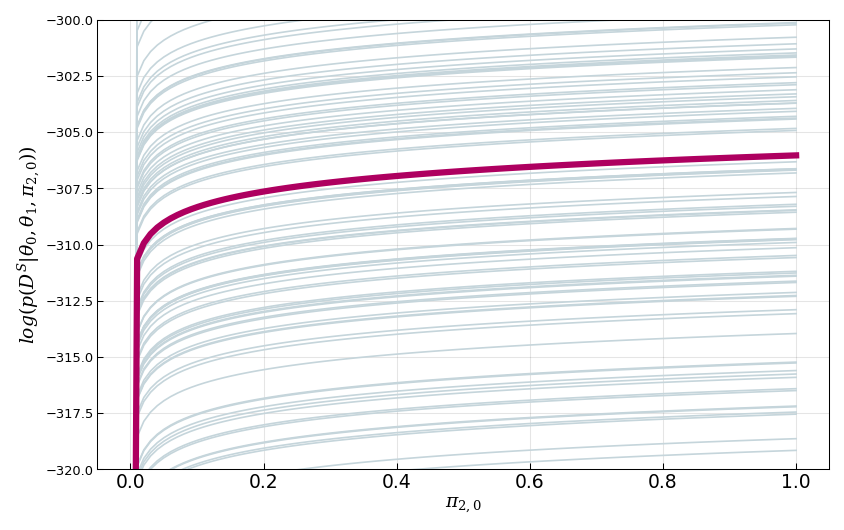

In [93]:
# How does it look like if we sample from the posterior?
n_lines = 100
random_idx = random.sample(range(len(samples_S00)), n_lines)

xs = np.linspace(0,1,100)
fig,ax = plt.subplots(1, figsize=set_size(width='full'))
for i in range(n_lines):
    ax.plot(xs, [log_prob_fixed_samples(x, samples_S00[random_idx[i]], samples_S01[random_idx[i]]) for x in xs] , color = usz_gray, linewidth = 0.8, linestyle = 'solid')
    
s0, s1 = samples_S00.mean(axis = 0), samples_S01.mean(axis = 0)
ax.plot(xs, [log_prob_fixed_samples(x, s0, s1) for x in xs] , color = usz_red, linewidth = 3)
ax.set_xlabel(r'$\pi_{2,0}$')
ax.set_ylabel(r'$log(p(D^S|{\theta_0, \theta_1, \pi_{2,0}}))$')
ax.set_ylim(bottom = -320, top = -300)
plt.show()
fig.savefig(PLOT_PATH / "line_llh_prob_dataS2_vs_mixing_cut.svg")

In [45]:
nwalkers, nstep, burnin = 25, 1000, 500
ndim_single = 1
print(f"Dimension: {ndim_single} with n walkers: {nwalkers}")
output_name = "samples_2_cluster_truefix_2123_synth"

random_idx = random.sample(range(samples_S00.shape[0]), nstep)

if True:
    samples = np.load("samples/"+output_name+".npy")
else:
    log_prob_fun =log_prob_fixed_samples
    emcee_args = [samples_S00.mean(axis = 0), samples_S01.mean(axis = 0)]
    created_pool = mp.Pool(os.cpu_count())
    with created_pool as pool:
        starting_points = np.random.uniform(size=(nwalkers, ndim_single))
        print(f"Start Burning (steps = {burnin}) with {created_pool._processes} cores")
        burnin_sampler = emcee.EnsembleSampler(
            nwalkers,
            ndim_single,
            log_prob_fun,
            args=emcee_args,
            pool=pool,
        )
        burnin_results = burnin_sampler.run_mcmc(
            initial_state=starting_points, nsteps=burnin, progress=True
        )
        
        ar = np.mean(burnin_sampler.acceptance_fraction)
        print(f"the HMM sampler for model 01 accepted {ar * 100 :.2f} % of samples.")
        last_sample = burnin_sampler.get_last_sample()[0]
        print(f"The shape of the last sample is {last_sample.shape}")
        starting_points = np.random.uniform(size=(nwalkers, ndim_single))
        original_sampler_mp = emcee.EnsembleSampler(
            nwalkers,
            ndim_single,
            log_prob_fun,
            args=emcee_args,
            backend=None,
            pool=pool,
        )
        sampling_results = original_sampler_mp.run_mcmc(
            initial_state=last_sample, nsteps=nstep, progress=True
        )

    ar = np.mean(original_sampler_mp.acceptance_fraction)
    print(f"the HMM sampler for model accepted {ar * 100 :.2f} % of samples.")
    samples = original_sampler_mp.get_chain(flat=True)
    np.save(f"./samples/" + output_name, samples)
    # plots["acor_times"].append(burnin_info["acor_times"][-1])
    # plots["accept_rates"].append(burnin_info["accept_rates"][-1])

Dimension: 1 with n walkers: 25


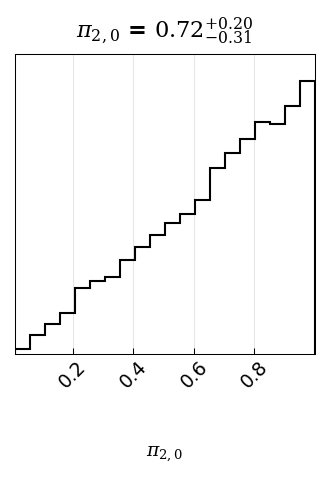

In [46]:

fig = corner.corner(
    samples,
    labels=[r'$\pi_{2,0}$'],
    show_titles=True,
)
plt.show()
fig.savefig(PLOT_PATH / "corner_single_mixing_true_fixed_theta.svg")

## Just check what happens if we sample all of the mixture components

In [47]:
global MODELS

graph = {
            ("tumor", "primary"): ["I", "II", "III"],
            ("lnl", "I"): [],
            ("lnl", "II"): ["I", "III"],
            ("lnl", "III"): [],
        }
models = create_models(3, graph = graph)

n_base_p = len(models[0].base_probs)
n_trans_p = len(models[0].trans_probs)
n_time_p = models[0].diag_time_dists.num_parametric
n_params_base = n_base_p + n_trans_p + n_time_p
ndim = n_params_base*2 + 1


# Load the data
for i, (s_name, s_data) in enumerate(data_s.items()):
    try:
        print(f"Loading data for subsite '{s_name}'.. Shape: {np.shape(s_data)}")
        models[i].patient_data = s_data
    except Exception as e:
        print(f"Error in loading data for cluster {s_name}.")
        print(e)
MODELS=models


Loading data for subsite 'S0'.. Shape: (190, 13)
Loading data for subsite 'S1'.. Shape: (350, 13)
Loading data for subsite 'S2'.. Shape: (202, 13)


In [105]:
n_clusters = 2
n_subsites = 3
ndim  = n_params_base*n_clusters + n_subsites

In [106]:
C = np.ones(shape=(n_subsites, n_clusters))*0.5
C

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]])

In [50]:
C = np.array([[1,0], [0,1], [0.5, 0.5]])

emcee_args = [n_params_base, n_clusters, n_subsites] 

In [95]:
def log_prob_k_cluster(theta, n_params_base, n_clusters, n_subsites):
    llh = 0
    for s in range(n_subsites):
        model = MODELS[s]
        log_sum = 0
        pi_s0 = theta[-s]
        pi_s1 = 1 - pi_s0    
        if pi_s0<0 or pi_s0> 1:
            return -np.inf
        params0 = theta[: n_params_base]
        params1 = theta[n_params_base: (2)*n_params_base]
        log_sum_0 = -np.inf
        log_sum_1 = -np.inf
        if pi_s0 != 0:
            log_sum_0 = np.log(pi_s0) + model.likelihood(given_params=params0, log = True)
        if pi_s1 != 0:
            log_sum_1 = np.log(pi_s1) + model.likelihood(given_params=params1, log = True)

        log_sum = np.logaddexp(log_sum_0, log_sum_1)
        # llh += ( C[s,k]*model.likelihood(given_params=params, log = True))
        llh += log_sum
    if np.isnan(llh):
        return -np.inf

    if np.isinf(llh):
        return -np.inf
    return llh

In [96]:
nwalkers, nstep, burnin = 400, 1000, 1500
print(f"Dimension: {ndim} with n walkers: {nwalkers}")
output_name = "samples_2_cluster_s0s1s2_nofix_2123_synth"

if True:
    samples = np.load("samples/"+output_name+".npy")
else:
    created_pool = mp.Pool(os.cpu_count())
    with created_pool as pool:
        starting_points = np.random.uniform(size=(nwalkers, ndim))
        print(f"Start Burning (steps = {burnin}) with {created_pool._processes} cores")
        burnin_sampler = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            log_prob_k_cluster,
            args=emcee_args,
            pool=pool,
        )
        burnin_results = burnin_sampler.run_mcmc(
            initial_state=starting_points, nsteps=burnin, progress=True
        )
        
        ar = np.mean(burnin_sampler.acceptance_fraction)
        print(f"the HMM sampler for model 01 accepted {ar * 100 :.2f} % of samples.")
        last_sample = burnin_sampler.get_last_sample()[0]
        print(f"The shape of the last sample is {last_sample.shape}")
        starting_points = np.random.uniform(size=(nwalkers, ndim))
        original_sampler_mp = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            log_prob_k_cluster,
            args=emcee_args,
            backend=None,
            pool=pool,
        )
        sampling_results = original_sampler_mp.run_mcmc(
            initial_state=last_sample, nsteps=nstep, progress=True
        )

    ar = np.mean(original_sampler_mp.acceptance_fraction)
    print(f"the HMM sampler for model accepted {ar * 100 :.2f} % of samples.")
    samples = original_sampler_mp.get_chain(flat=True)
    np.save(f"./samples/" + output_name, samples)
    # plots["acor_times"].append(burnin_info["acor_times"][-1])
    # plots["accept_rates"].append(burnin_info["accept_rates"][-1])


Dimension: 13 with n walkers: 400


In [107]:
samples_nofix_cl0 = samples[:,:n_params_base]
samples_nofix_cl0 = samples[:,n_params_base:2*n_params_base]




In [108]:
mixing_params = np.column_stack([samples[:,-n_subsites:], 1-samples[:,-n_subsites:]])

In [109]:
mixing_params

array([[ 9.68810741e-02,  4.19931090e-01,  8.09834608e-01,
         9.03118926e-01,  5.80068910e-01,  1.90165392e-01],
       [ 7.34949756e+02,  8.27462347e-01,  3.29698994e-01,
        -7.33949756e+02,  1.72537653e-01,  6.70301006e-01],
       [ 1.74032839e-01,  4.62174477e-01,  4.22738426e-02,
         8.25967161e-01,  5.37825523e-01,  9.57726157e-01],
       ...,
       [ 1.08387705e-01,  5.14325983e-01,  8.11462458e-01,
         8.91612295e-01,  4.85674017e-01,  1.88537542e-01],
       [ 2.91854597e+05,  8.44041227e-01,  9.66992840e-01,
        -2.91853597e+05,  1.55958773e-01,  3.30071600e-02],
       [-7.55593130e+04,  8.95329095e-01,  9.84624833e-01,
         7.55603130e+04,  1.04670905e-01,  1.53751666e-02]])

In [111]:
model_labels = get_model_labels(models)
mixing_labels = [r'$\pi_{00}$', r'$\pi_{10}$', r'$\pi_{20}$', r'$\pi_{01}$', r'$\pi_{11}$', r'$\pi_{21}$']

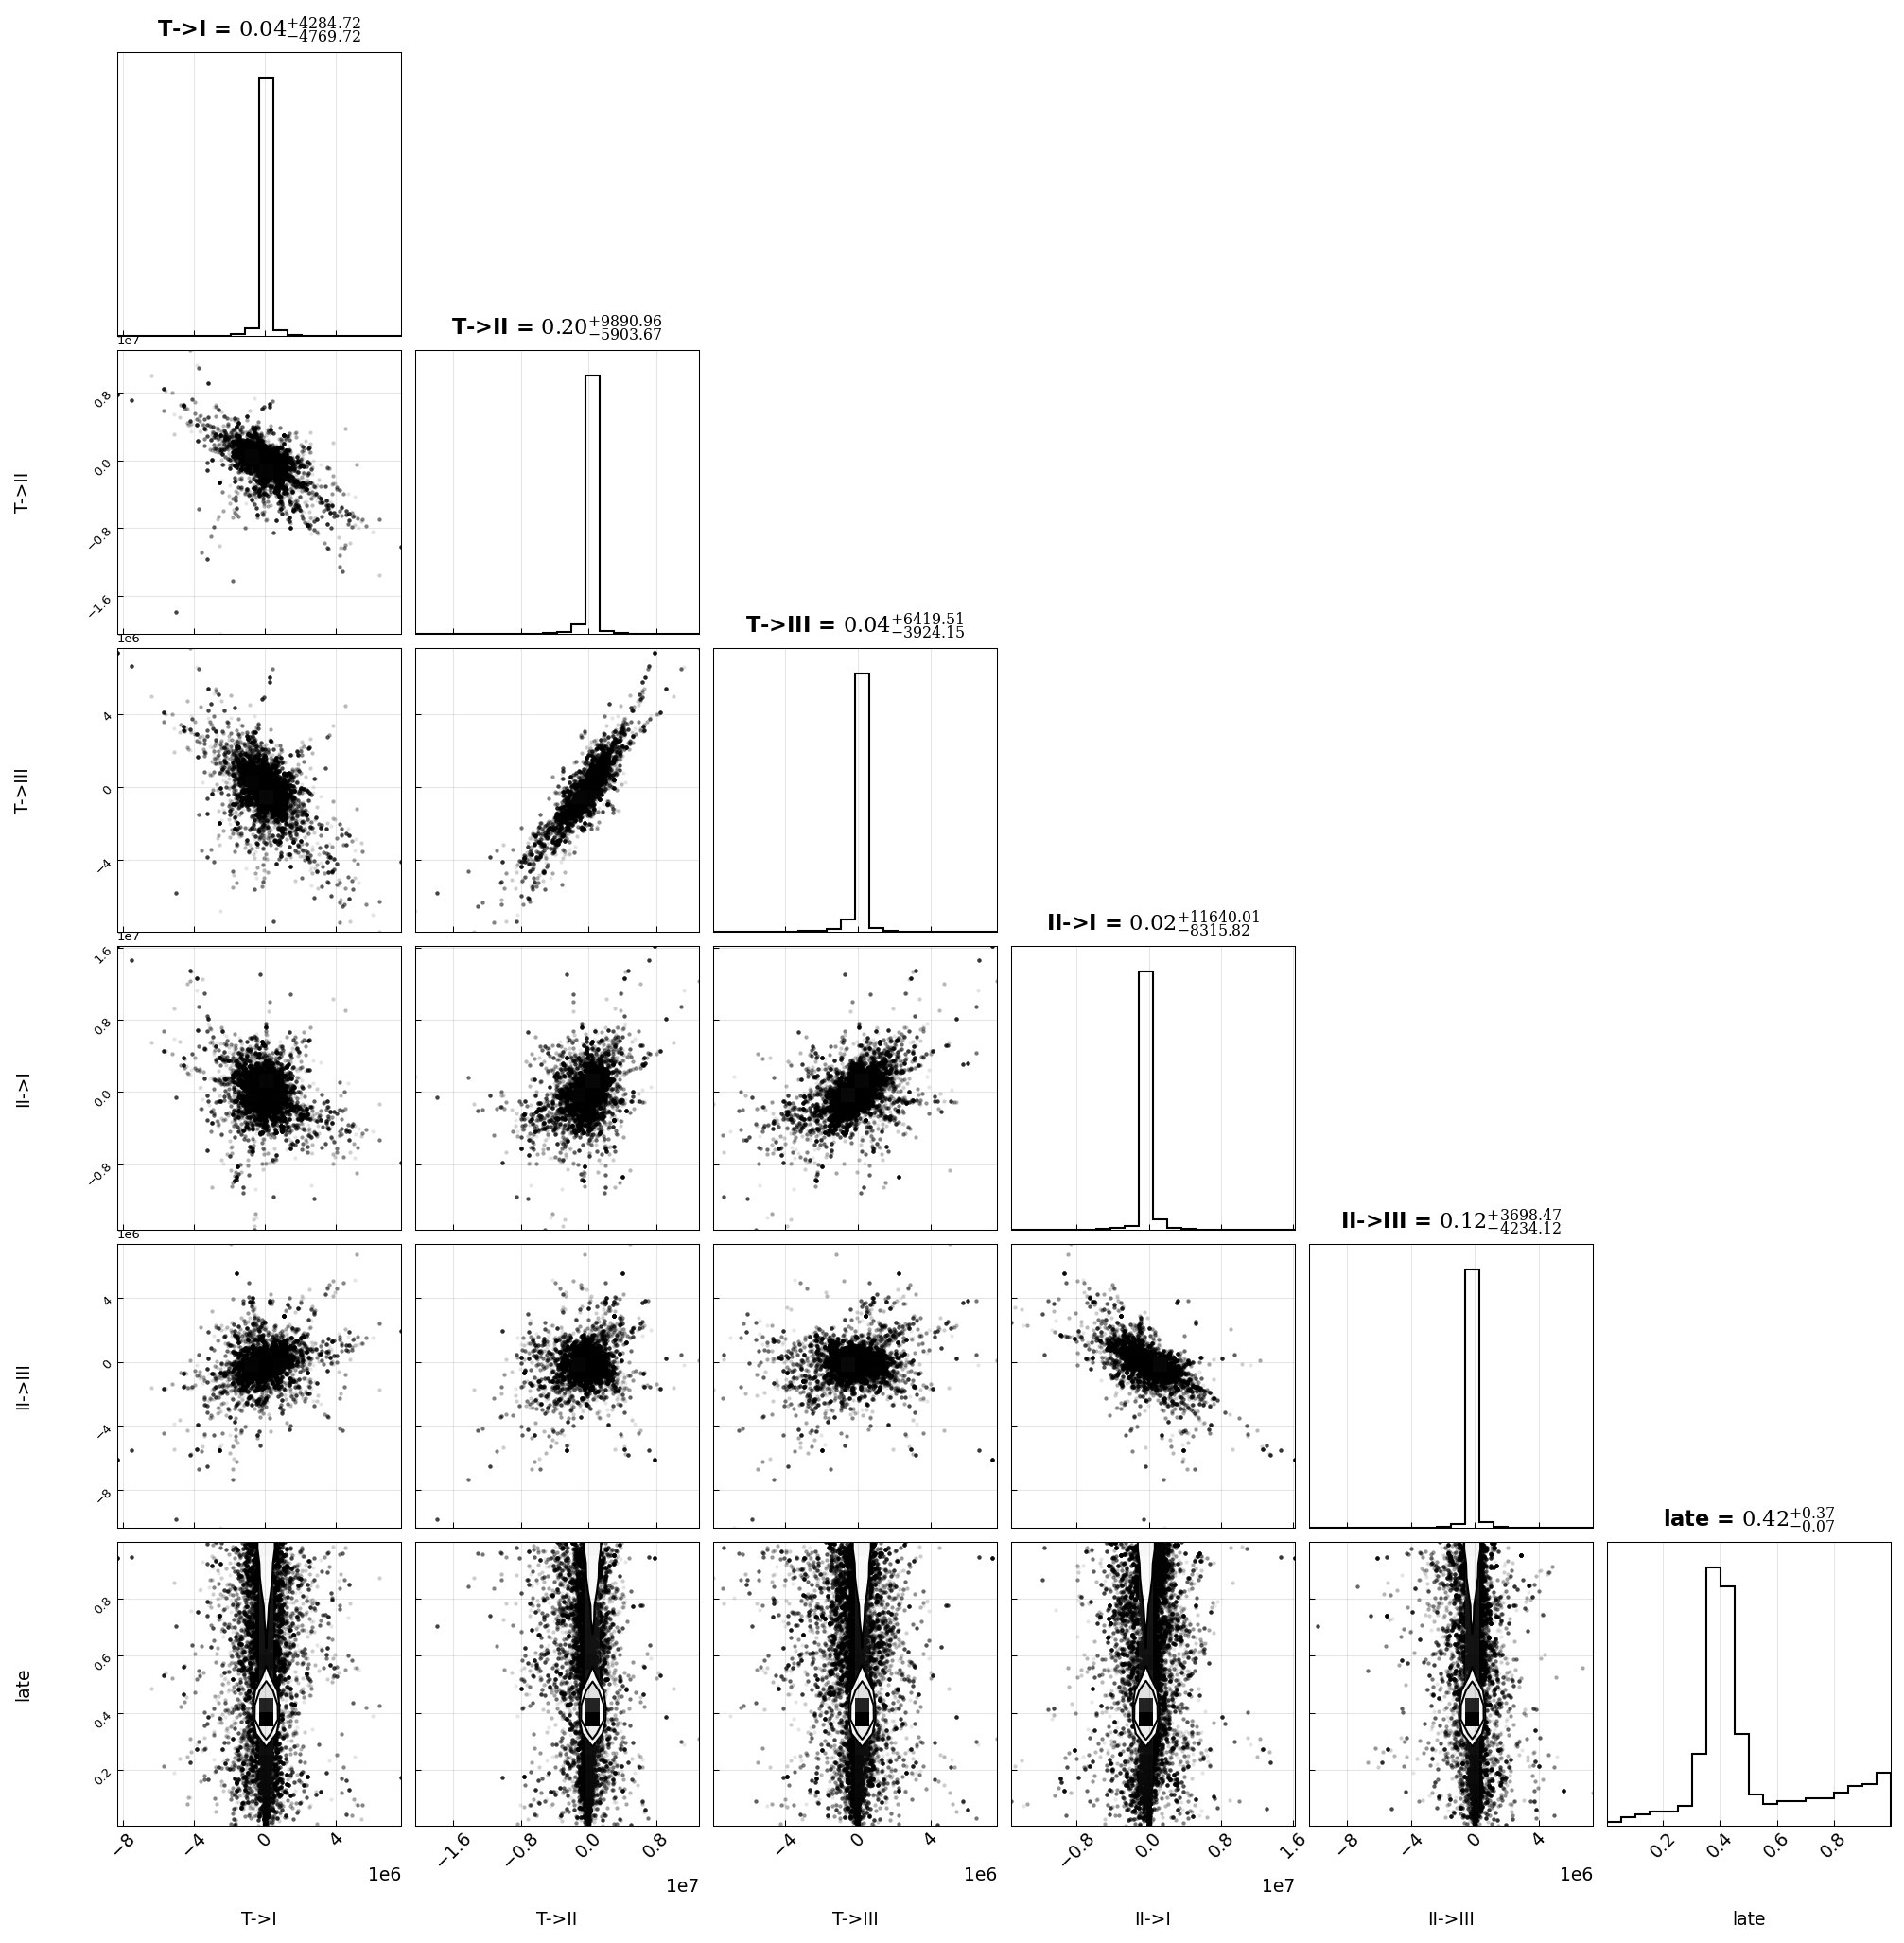

In [101]:
fig = corner.corner(
    data = samples_nofix_cl0,
    labels = model_labels,
    show_titles=True
)
plt.show()
fig.savefig(PLOT_PATH / "corner_samples_nofix_cl0_2_cluster_s0s1s2_nofix_2123_synth.svg")

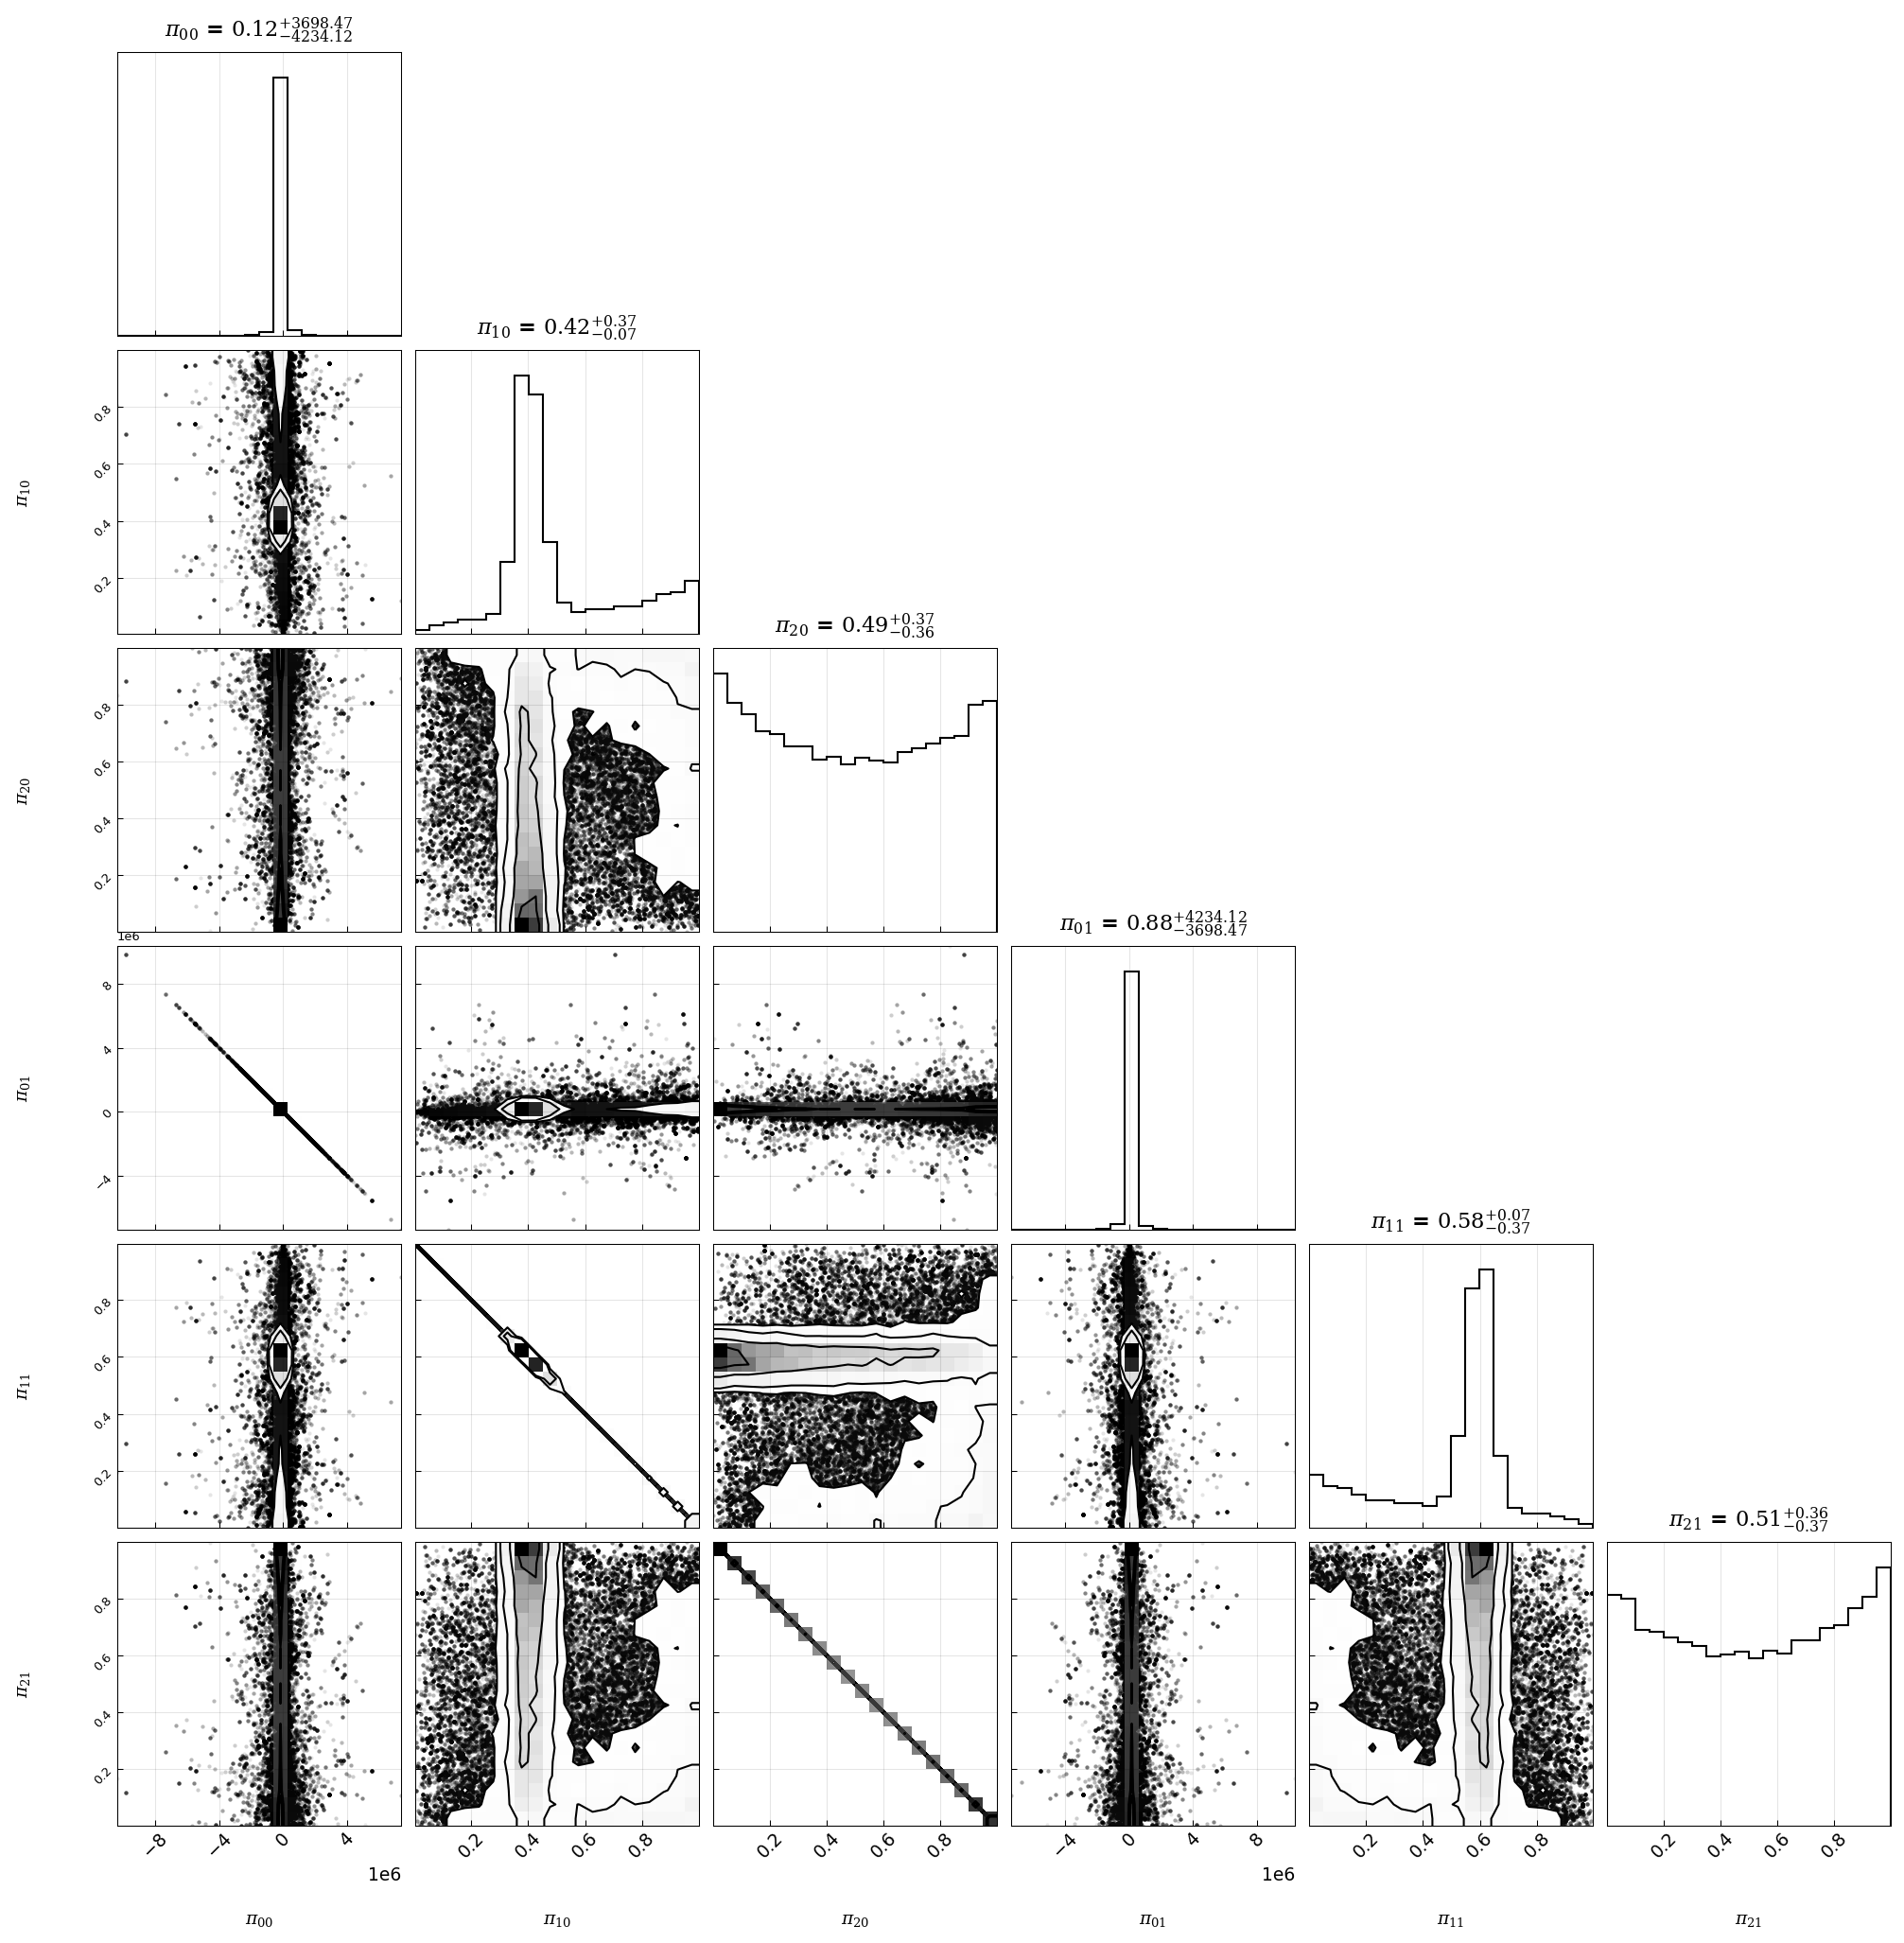

In [112]:
fig = corner.corner(
    data = mixing_params,
    labels = mixing_labels,
    show_titles=True
)
plt.show()
fig.savefig(PLOT_PATH / "corner_mixing_params_2_cluster_s0s1s2_nofix_2123_synth.svg")

In [75]:
# Looks shit, as expected

In [ ]:
## Use the new lymph package (lymph_forked (version V1.0.01)) to continue.

In [4]:
import sys
sys.path.append("/Users/juli/Studium/Master/FS23/masterthesis/code/lymph_forked")  
import lymph_forked


In [31]:
graph = {
            ("tumor", "primary"): ["I", "II", "III"],
            ("lnl", "I"): [],
            ("lnl", "II"): ["I", "III"],
            ("lnl", "III"): [],
        }

In [32]:
model = lymph_forked.models.Unilateral(graph_dict=graph)

In [36]:
pathological_spsn = {
        "max_llh": [1.0, 1.0],
    }
model.modalities = pathological_spsn
print(model.modalities['max_llh'])

[[1. 0.]
 [0. 1.]]


In [44]:
import scipy as sp

In [57]:


def late_binomial(support: np.ndarray, p: float = 0.5) -> np.ndarray:
    """Parametrized binomial distribution."""
    n = support[-1]
    pmf = np.fromiter((np.math.comb(n, k) * np.power(p, k) * np.power(1 - p, n - k) for k in support), dtype=float)
    return pmf


def create_models_forked(n,  graph = None):
    if graph is None:
        graph = {
            ("tumor", "primary"): ["I", "II", "III", "IV"],
            ("lnl", "I"): [],
            ("lnl", "II"): ["I", "III"],
            ("lnl", "III"): ["IV"],
            ("lnl", "IV"): [],
        }

    diagnostic_spsn = {
        "max_llh": [1.0, 1.0],
    }


    max_t = 10
    first_binom_prob = 0.3

    models = []
    for i in range(n):
        model = lymph_forked.models.Unilateral(graph_dict=graph)
        model.modalities = diagnostic_spsn

        max_time = model.max_time
        time_steps = np.arange(max_time+1)
        p = 0.4

        early_prior = sp.stats.binom.pmf(time_steps, max_time, p)
        model.diag_time_dists["early"] = early_prior
        model.diag_time_dists["late"] = late_binomial
        
        models.append(model)
    if n>1:
        return models
    else:
        return models[0]

In [58]:
model = create_models_forked(1, graph = graph)
model.get_params(as_dict=True)

/Users/juli/Studium/Master/FS23/masterthesis/code/lymph_forked/lymph_forked/descriptors/diagnose_times.py:140: UserWarning: Distribution is not updateable, returning empty dict
  warnings.warn("Distribution is not updateable, returning empty dict")


{'spread_primary_to_I': 0.0,
 'spread_primary_to_II': 0.0,
 'spread_primary_to_III': 0.0,
 'spread_II_to_I': 0.0,
 'spread_II_to_III': 0.0,
 'late_p': 0.5}

In [63]:

data_s0_s1_tf = pd.concat([data_s['S0'],data_s['S1'] ])


In [74]:
model.load_patient_data(data, side='ipsi')

In [75]:
model.patient_data['_model']

max_llh                     #
          I     II    III t_stage
0     False  False  False   early
1     False  False  False   early
2     False  False  False   early
3      True  False   True    late
4     False  False  False   early
..      ...    ...    ...     ...
964   False   True  False   early
965   False  False  False    late
966   False  False  False   early
967   False  False  False   early
968   False  False   True   early

[969 rows x 4 columns]

## Create Synthetic dataset

In [130]:
graph = {
    ("tumor", "primary"): ["I", "II", "III"],
    ("lnl", "I"): [],
    ("lnl", "II"): ["I", "III"],
    ("lnl", "III"): [],
}
lnls = ['I', 'II', 'III']

In [126]:
model = create_models_forked(1, graph=graph)
model.get_params(as_dict=True)

/Users/juli/Studium/Master/FS23/masterthesis/code/lymph_forked/lymph_forked/descriptors/diagnose_times.py:140: UserWarning: Distribution is not updateable, returning empty dict
  warnings.warn("Distribution is not updateable, returning empty dict")


{'spread_primary_to_I': 0.0,
 'spread_primary_to_II': 0.0,
 'spread_primary_to_III': 0.0,
 'spread_II_to_I': 0.0,
 'spread_II_to_III': 0.0,
 'late_p': 0.5}

In [117]:
params_s0 = [0.5, 0, 0.05, 0.00, 0.1, 0.5]
params_s1 = [0, 0.5, 0.05, 0.00, 0.1, 0.5]
# params_s2 = [0.2, 0.02, 0.05, 0.00, 0.1, 0.5]

t_dist = {'early': 0.6, 'late': 0.4}

In [133]:
model.assign_params(*params_s0)
data_synth_s0 = model.generate_dataset(150, t_dist)
data_synth_s0.head()

max_llh                  info
        I     II    III t_stage
0   False  False   True   early
1    True  False  False    late
2   False  False  False   early
3    True  False   True    late
4    True  False  False   early

 State: {'III': 1, 'II': 1, 'I': 1}

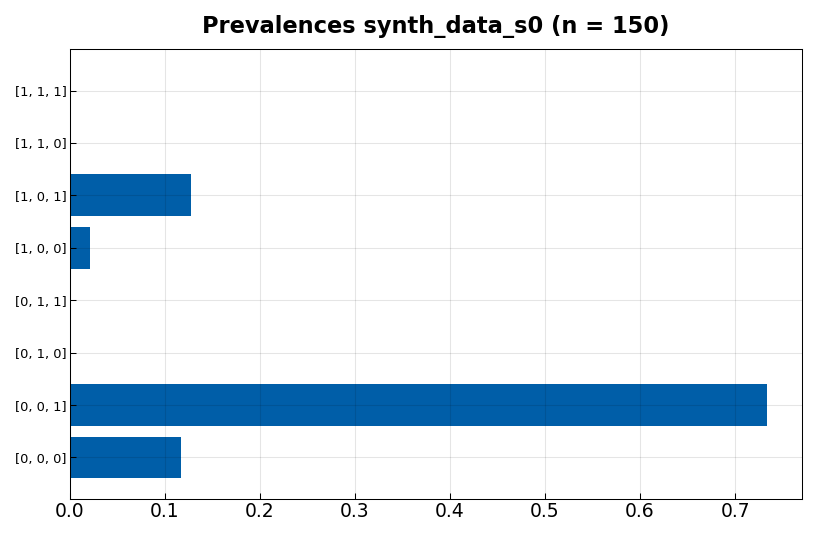

In [134]:
prev_synth_s0 = create_prev_vectors(data_synth_s0, lnls,  plot=True, title='synth_data_s0')

In [135]:
model.assign_params(*params_s1)
data_synth_s1 = model.generate_dataset(150, t_dist)
data_synth_s1.head()

max_llh                 info
        I    II    III t_stage
0   False  True  False   early
1   False  True  False    late
2   False  True  False   early
3   False  True  False    late
4   False  True   True    late

 State: {'III': 1, 'II': 1, 'I': 1}

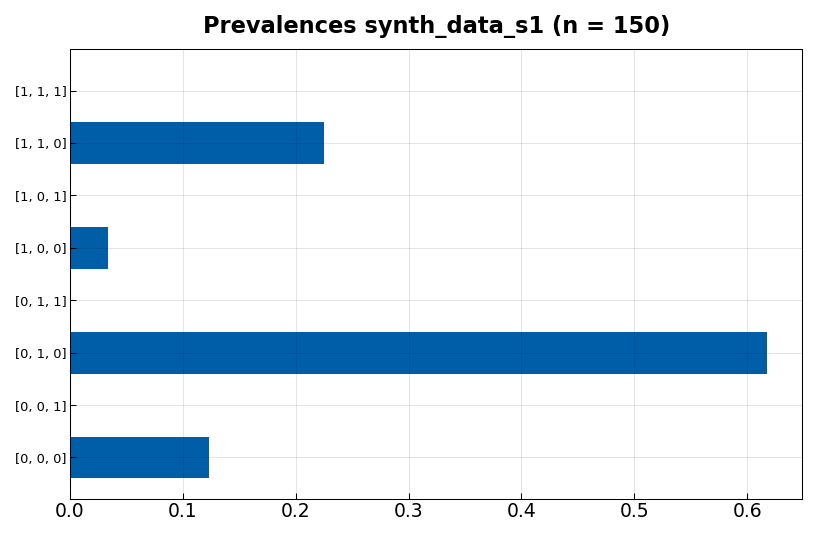

In [136]:
prev_synth_s1 = create_prev_vectors(data_synth_s1, lnls,  plot=True, title='synth_data_s1')

In [141]:
model.assign_params(*params_s0)
data_synth_s0_30 = model.generate_dataset(30, t_dist)
model.assign_params(*params_s1)
data_synth_s1_30 = model.generate_dataset(30, t_dist)

data_synth_s2 = pd.concat([data_synth_s0_30, data_synth_s1_30], ignore_index=True)
data_synth_s2.head()

max_llh                  info
        I     II    III t_stage
0    True  False  False   early
1    True  False  False   early
2    True  False  False   early
3    True  False  False   early
4    True  False  False    late

 State: {'III': 1, 'II': 1, 'I': 1}

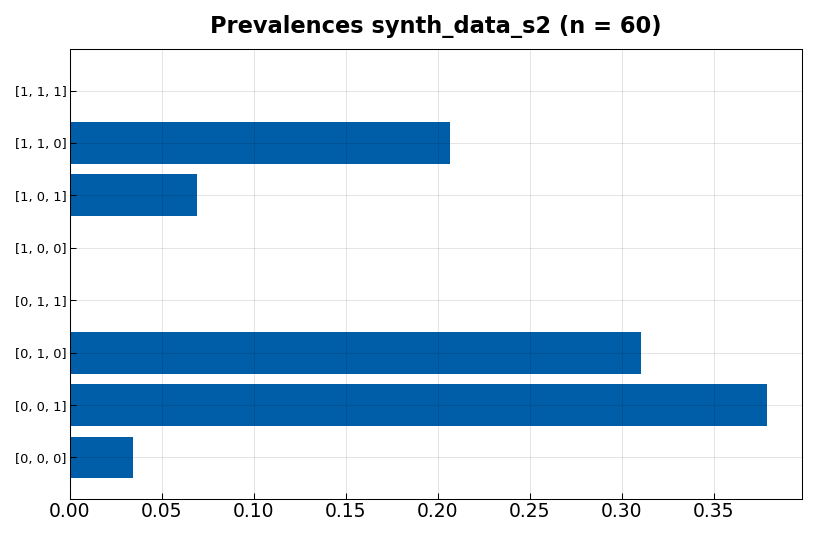

In [142]:
prev_synth_s2 = create_prev_vectors(data_synth_s2, lnls,  plot=True, title='synth_data_s2')

In [143]:
n_params_base = len(model.get_params(as_dict=True))

/Users/juli/Studium/Master/FS23/masterthesis/code/lymph_forked/lymph_forked/descriptors/diagnose_times.py:140: UserWarning: Distribution is not updateable, returning empty dict
  warnings.warn("Distribution is not updateable, returning empty dict")


In [ ]:
models = create_models_forked(3, graph)
n_params_base = len(model.get_params(as_dict=True))
n_base_p = len(models[0].base_probs)
n_trans_p = len(models[0].trans_probs)
n_time_p = models[0].diag_time_dists.num_parametric
n_params_base = n_base_p + n_trans_p + n_time_p
ndim = n_params_base*2 + 1


### ML Approach

In [5]:
graph = {
            ("tumor", "primary"): ["I", "II"],
            ("lnl", "I"): [],
            ("lnl", "II"): [],
        }
graph_lnl_I_II = graph
lnls = ['I', 'II']

model_data_gen = create_models_forked(1, graph=graph)
model_data_gen.get_params(as_dict=True)

params_s0 = [0.6, 0.0, 0.5]
params_s1 = [0.0, 0.6, 0.5]

t_dist = {'early': 0.6, 'late': 0.4}

/Users/juli/Studium/Master/FS23/masterthesis/code/lymph_forked/lymph_forked/descriptors/diagnose_times.py:140: UserWarning: Distribution is not updateable, returning empty dict
  warnings.warn("Distribution is not updateable, returning empty dict")


In [6]:
model_data_gen.assign_params(*params_s0)
D1 = model_data_gen.generate_dataset(300, t_dist)
D1.head()

max_llh           info
        I     II t_stage
0    True  False    late
1    True  False    late
2    True  False    late
3    True  False   early
4    True  False   early

In [7]:
model_data_gen.assign_params(*params_s1)
D2 = model_data_gen.generate_dataset(300, t_dist)
D2.head()

max_llh          info
        I    II t_stage
0   False  True   early
1   False  True   early
2   False  True   early
3   False  True   early
4   False  True   early

In [147]:


D12 = create_synth_data(params_s0, params_s1, 300, 0.4, graph, t_dist)
D12.head()

max_llh           info
        I     II t_stage
0    True  False    late
1    True  False   early
2    True  False   early
3   False  False   early
4   False  False   early

 State: {'II': 1, 'I': 1}

/var/folders/69/p_wbqzyx3031kxyydgwqmnnh0000gn/T/ipykernel_12138/4192845363.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


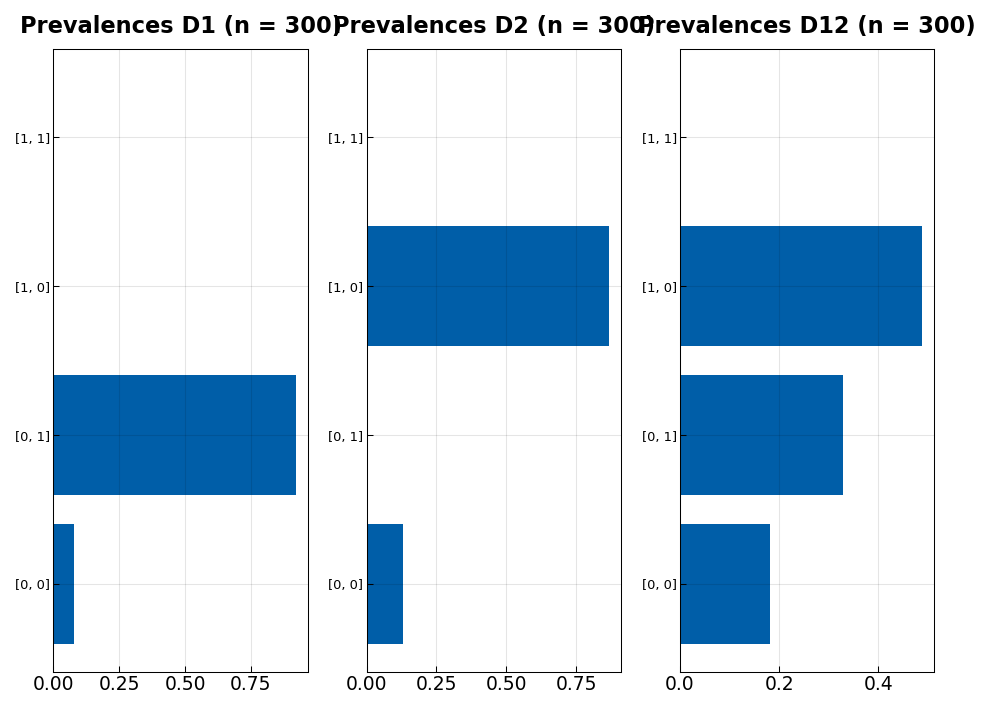

In [148]:
fig, ax = plt.subplots(1, 3, tight_layout = True)
create_prev_vectors(D1, lnls, plot=True, title='D1', ax = ax[0])
create_prev_vectors(D2, lnls, plot=True, title='D2', ax = ax[1])
create_prev_vectors(D12, lnls, plot=True, title='D12', ax = ax[2])
fig.show()

In [149]:
method = 'unilateral'
used_model = 'indp'
models = create_models(2, graph)
n_base_p = len(models[0].base_probs)
n_trans_p = len(models[0].trans_probs)
n_time_p = models[0].diag_time_dists.num_parametric
n_params_base = n_base_p + n_trans_p + n_time_p


In [150]:
from scipy.optimize import minimize

In [151]:
# Define the likelihood function
def func(params, model_llh):
    if 0 in params or 1 in params:
        return 1000
    params_model = np.concatenate((params, np.array([1]))) 
    llh =  -model_llh.likelihood(given_params = params_model, mode='BN')
    return llh

In [152]:
bounds = [(0, 1), (0, 1)]
initial_guess = np.array([0.5,0.5])

In [136]:
# Get the MLE for each of the datasets using the independent models
model_d1 = models[0]
model_d1.load_data(data = D1, mode='BN')

res = minimize(func, x0 = initial_guess, args = model_d1, bounds = bounds)
print(f"For D1: b1 = {res.x[0]:.2f}, b2 = {res.x[1]:.2f}")

For D1: b1 = 0.94, b2 = 0.00


In [88]:
# Get the MLE for each of the datasets using the independent models
model = models[0]
model.load_data(data = D2, mode='BN')

res = minimize(func, x0 = initial_guess, args = model, bounds = bounds)
print(f"For D2: b1 = {res.x[0]:.2f}, b2 = {res.x[1]:.2f}")


For D2: b1 = 0.00, b2 = 0.90


In [95]:
# Now we load model 1 with D1, model 2 with D2 and model 3 with D3.
global MODElS
MODELS = create_models(3, graph=graph_lnl_I_II)
MODELS[0].load_data(data = D1, mode='BN')
MODELS[1].load_data(data = D2, mode='BN')
MODELS[2].load_data(data = D12, mode='BN')

In [165]:
def log_prob_2_cluster_minimize(theta, n_params_base, n_clusters, n_subsites):
    if 0 in theta or 1 in theta:
        return 10000
    t0 = np.concatenate((theta[: n_params_base], np.array([1]))) 
    t1 = np.concatenate((theta[n_params_base: (2)*n_params_base], np.array([1]))) 
    pi = [1, 0 , theta[-1]]
    llh = 0
    for s in range(n_subsites):
        model = MODELS[s]
        log_sum = 0
        pi_s0 = pi[s]
        pi_s1 = 1 - pi_s0    
        if pi_s0<0 or pi_s0> 1:
            return 10000

        log_sum_0 = -np.inf
        log_sum_1 = -np.inf
        if pi_s0 != 0:
            log_sum_0 = np.log(pi_s0) + model.likelihood(given_params=t0, mode = 'BN', log = True)
        if pi_s1 != 0:
            log_sum_1 = np.log(pi_s1) + model.likelihood(given_params=t1, mode = 'BN', log = True)

        log_sum = np.logaddexp(log_sum_0, log_sum_1)
        # llh += ( C[s,k]*model.likelihood(given_params=params, log = True))
        llh += log_sum
    if np.isnan(llh):
        return 10000

    if np.isinf(llh):
        return 10000
    return -llh


In [170]:
initial_guess = np.array([0.5,0.5,0.5,0.5,0.5])
bounds = [(0, 1), (0, 1), (0,1), (0,1), (0,1)]

In [171]:
res = minimize(
    log_prob_2_cluster_minimize, x0=initial_guess, args=(2, 2, 3), bounds=bounds
)
print(
    f"MLE: b1_a = {res.x[0]:.2f}, b2_a = {res.x[1]:.2f}, b1_b = {res.x[2]:.2f}, b2_b = {res.x[3]:.2f}, pi_12_a = {res.x[4]:.2f}"
)

MLE: b1_a = 0.94, b2_a = 0.00, b1_b = 0.18, b2_b = 0.73, pi_12_a = 0.00


We see that also if we take the full likelihood of the model (given the data) then MLE will just fully assign D12 to one of the clusters.

In [172]:
log_prob_2_cluster_minimize(np.array([0.9,0.001,0.001,0.9,0.0011]), 2,2, 3)

1229.9341191869876

In [125]:
initial_guess[-1]

0.5

In [126]:
m = MODELS[2]

In [130]:
m.likelihood(given_params=np.array([0.9,0.9,1]), mode = 'BN', log = True)

-788.3004199156483

In [134]:
import numpy as np
import matplotlib.pyplot as plt

# Define a grid of parameter values
x_values = np.linspace(0, 1, 100)  # 100 points between 0 and 1 for the first parameter
y_values = np.linspace(0, 1, 100)  # 100 points between 0 and 1 for the second parameter

# Create a meshgrid from the parameter values
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Calculate the likelihood for each combination of parameter values
likelihood_values = np.zeros_like(x_grid)

for i in range(len(x_values)):
    for j in range(len(y_values)):
        params = [x_values[i], y_values[j], 1]
        likelihood_values[i][j] = m.likelihood(given_params=np.array(params), mode = 'BN', log = True)  # Replace with your likelihood function




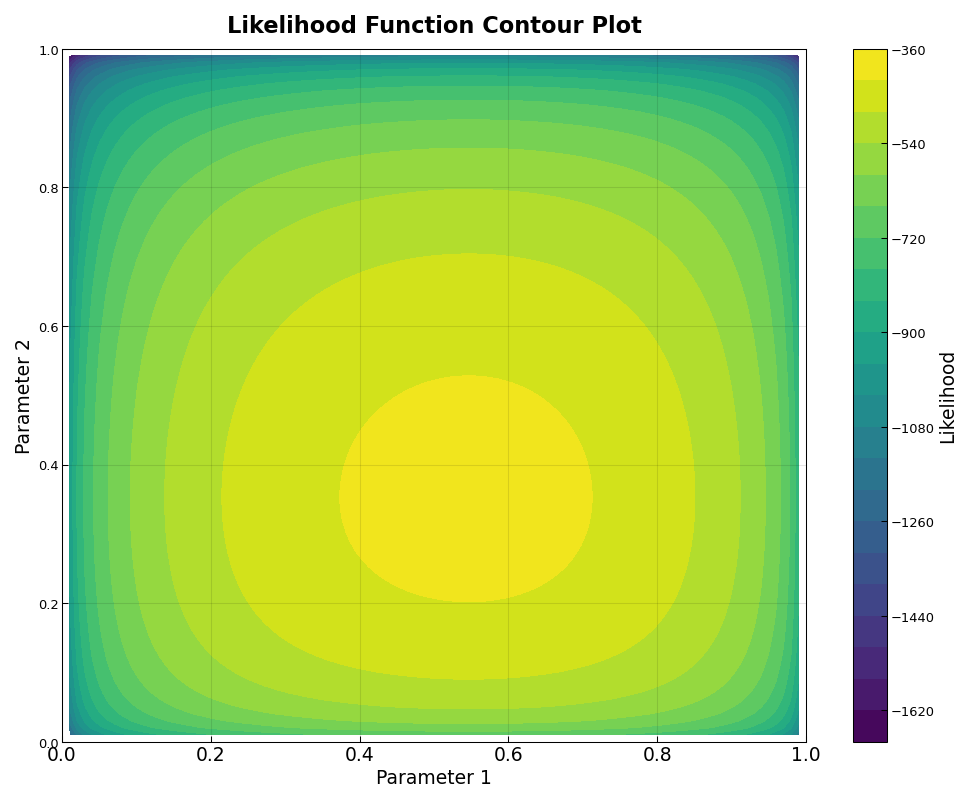

In [133]:
# Create a contour plot of the likelihood function
plt.figure(figsize=(8, 6))
contour = plt.contourf(x_grid, y_grid, likelihood_values, cmap='viridis', levels = 20)
plt.colorbar(contour, label='Likelihood')
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
plt.title('Likelihood Function Contour Plot')
plt.grid(True)
plt.show()

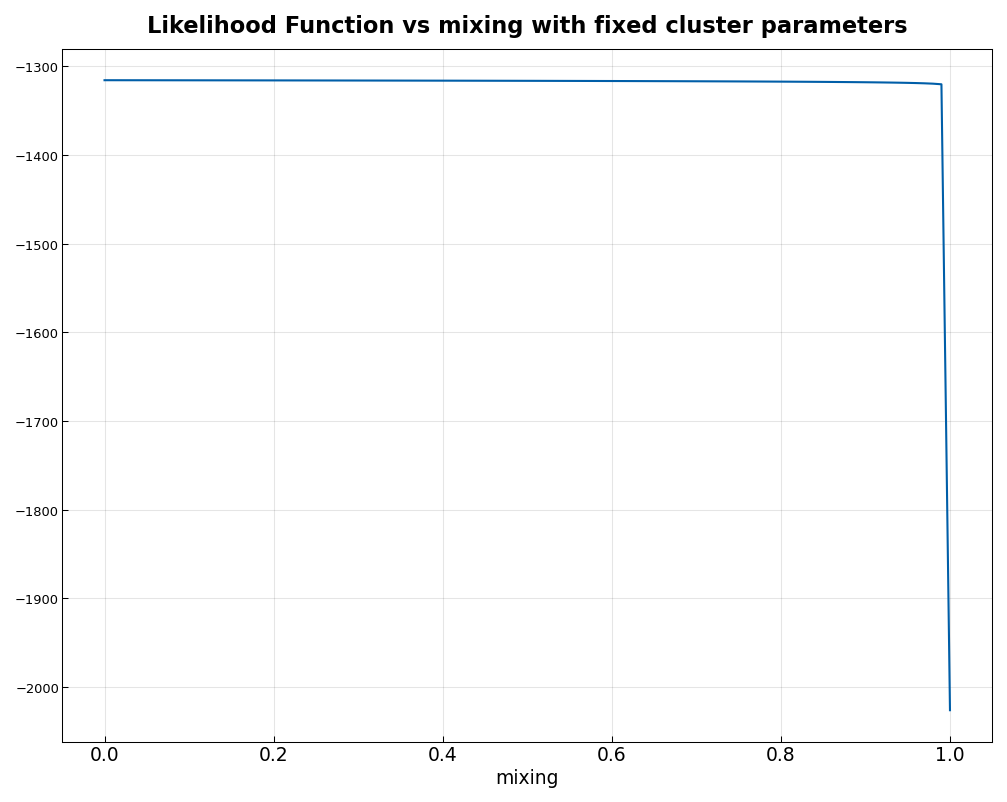

In [155]:
t0 = np.array([0.94, 0.0001, 1 ])
t1 = np.array([0.0001, 0.9, 1 ])
model = create_models(1, graph_lnl_I_II)
model.load_data(D12, mode ='BN')
mixing = np.linspace(0, 1, 100)  # 100 points between 0 and 1 for the second parameter

llhs = []
for w in mixing:
    log_sum_0 = -np.inf
    log_sum_1 = -np.inf
    if w != 0:
        log_sum_0 = np.log(w) + model.likelihood(given_params=t0, mode = 'BN', log = True)
    if (1-w) != 0:
        log_sum_1 = np.log(1-w) + model.likelihood(given_params=t1, mode = 'BN', log = True)

    log_sum = np.logaddexp(log_sum_0, log_sum_1)
    llhs.append(log_sum)

# Create a contour plot of the likelihood function
plt.figure(figsize=(8, 6))
contour = plt.plot(mixing, llhs)

plt.xlabel('mixing')

plt.title('Likelihood Function vs mixing with fixed cluster parameters')
plt.grid(True)
plt.show()


In [156]:
model.likelihood(given_params=t0, mode = 'BN', log = True)

-2026.0289320618176

In [154]:
model.likelihood(given_params=t1, mode = 'BN', log = True)

-1601.1430415894056

We see that also if we take the full likelihood of the model (given the data) then MLE will just fully assign D12 to one of the clusters.

In [1]:
model

NameError: name 'model' is not defined

# Hello Test 

In [4]:
import numpy as np

In [5]:
x = np.linspace(0,1,100)

In [6]:
x

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [7]:
y = [np.sin(xs) for xs in x]

In [8]:
y

[0.0,
 0.01010083833352769,
 0.02020064608319138,
 0.03029839277027705,
 0.04039304812635997,
 0.05048358219842245,
 0.06056896545393953,
 0.07064816888592167,
 0.08072016411790384,
 0.09078392350887036,
 0.10083842025810462,
 0.110882628509953,
 0.12091552345849253,
 0.1309360814520914,
 0.14094328009785154,
 0.15093609836592295,
 0.16091351669367898,
 0.17087451708974177,
 0.18081808323784737,
 0.19074320060054012,
 0.20064885652268544,
 0.21053404033479045,
 0.22039774345612229,
 0.23023895949761297,
 0.24005668436454086,
 0.24984991635897805,
 0.25961765628199307,
 0.26935890753559866,
 0.2790726762244343,
 0.28875797125717284,
 0.2984138044476411,
 0.308039190615644,
 0.3176331476874822,
 0.32719469679615226,
 0.3367228623812205,
 0.3462166722883586,
 0.35567515786853215,
 0.3650973540768315,
 0.37448229957093493,
 0.3838290368091937,
 0.39313661214832984,
 0.4024040759407358,
 0.4116304826313666,
 0.4208148908542144,
 0.4299563635283556,
 0.4390539679535607,
 0.44810677590545755,

In [10]:
import matplotlib.pyplot as plt

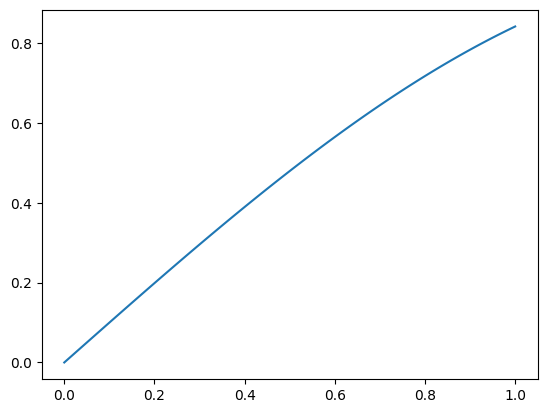

In [11]:
plt.plot(x,y)

This is somethng

## Fit a line